In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
import copy
import seaborn as sns

In [2]:
df_d = pd.read_csv("Dutch_new_all_session.csv")
df_h = pd.read_csv("Honolulu_rounded_and_accurate_all_session.csv")
df_d = df_d[df_d["subsession.round_number"] > 2]
df_h = df_h[df_h["subsession.round_number"] > 2]

In [3]:
dict_all = dict()
for index, row in df_d.iterrows():
    key = (row["session.code"], row["subsession.round_number"], row["group.id_in_subsession"])

    if key not in dict_all:
        dict_all[key] = {
            "session_name": row["session.config.name"],
            "discount": row["session.config.discount_b"],
            "d_dutch_final_price": row["group.dutch_final_price"],
            "d_item_value": [],
            "d_dutch_winner_item_value": 0,
            "d_dutch_winner_value_rank": 0,
            "d_dutch_winner_optimal_bid": 0,
            "h_dutch_final_price": None,
            "h_item_value": [],
            "h_dutch_winner_item_value": 0,
            "h_dutch_winner_value_rank": 0,
            "h_dutch_winner_optimal_bid": 0,
            "h_contest_leave_item_value": [],
            "h_english_num_player": 0,
            "h_english_leave_item_value": [],
            "h_english_leave_price": [],
        }

    dict_all[key]["d_item_value"].append(row["player.item_value"])
    
    if row["player.is_dutch_winner"] == 1:
        dict_all[key]["d_dutch_winner_item_value"] = row["player.item_value"]
        dict_all[key]["d_dutch_winner_optimal_bid"] = row["predict.player.bid"]

tmp_dict = dict()
for index, row in df_h.iterrows():
    key = (row["session.code"], row["subsession.round_number"], row["group.id_in_subsession"])

    if dict_all[key]["h_dutch_final_price"] == None:
        dict_all[key]["h_dutch_final_price"] = row["group.dutch_final_price"]
        
    dict_all[key]["h_item_value"].append(row["player.item_value"])

    if row["player.is_dutch_winner"] == 1:
        dict_all[key]["h_dutch_winner_item_value"] = row["player.item_value"]
        dict_all[key]["h_dutch_winner_optimal_bid"] = row["predict.player.optimal_dutch_bid"]

    dict_all[key]["h_english_num_player"] = row["group.have_contest_winner"]

    if row["player.contest_status"] != 1:
        dict_all[key]["h_contest_leave_item_value"].append(row["player.item_value"])
    elif (dict_all[key]["h_english_num_player"] > 1) and (row["player.is_english_winner"] == 0):
        dict_all[key]["h_english_leave_item_value"].append(row["player.item_value"])
        dict_all[key]["h_english_leave_price"].append(row["player.dropout_price"])

for key in dict_all.keys():
    tmp_list = dict_all[key]["d_item_value"]
    tmp_val = dict_all[key]["d_dutch_winner_item_value"]
    tmp_rank = 1
    for val in tmp_list:
        if val > tmp_val:
            tmp_rank += 1
    dict_all[key]["d_dutch_winner_value_rank"] = tmp_rank

    tmp_list = dict_all[key]["h_item_value"]
    tmp_val = dict_all[key]["h_dutch_winner_item_value"]
    tmp_rank = 1
    for val in tmp_list:
        if val > tmp_val:
            tmp_rank += 1
    dict_all[key]["h_dutch_winner_value_rank"] = tmp_rank

In [4]:
tmp = dict()
for p_code in set(df_d["participant.code"]):
    tmp[p_code] = np.sum(df_d[df_d["participant.code"] == p_code]["predict.player.payoff"])
for key in tmp.keys():
    if tmp[key] == 0:
        tmp[key] = 1e-6
df_d["paydiff_norm"] = (df_d["participant.dutch_payoff"] - df_d["participant.code"].map(tmp)) / df_d["session.config.num_formal_rounds"]
df_d["paydiff_pct"] = df_d["participant.dutch_payoff"] / df_d["participant.code"].map(tmp)
df_d["predict.round_payoff"] = df_d["participant.code"].map(tmp) / df_d["session.config.num_formal_rounds"]
tmp = dict()
for p_code in set(df_h["participant.code"]):
    tmp[p_code] = np.sum(df_h[df_h["participant.code"] == p_code]["predict.player.payoff"])
for key in tmp.keys():
    if tmp[key] == 0:
        tmp[key] = 1e-6
df_h["paydiff_norm"] = (df_h["participant.honolulu_payoff"] - df_h["participant.code"].map(tmp)) / df_h["session.config.num_formal_rounds"]
df_h["paydiff_pct"] = df_h["participant.honolulu_payoff"] / df_h["participant.code"].map(tmp)
df_h["predict.round_payoff"] = df_h["participant.code"].map(tmp) / df_h["session.config.num_formal_rounds"]

In [5]:
d_dict_paydiff_norm = {
    (5, 0.019): dict(),
    (5, 0.009): dict(),
    (2, 0.019): dict(),
    (2, 0.009): dict(),
}
d_dict_paydiff_pct = {
    (5, 0.019): dict(),
    (5, 0.009): dict(),
    (2, 0.019): dict(),
    (2, 0.009): dict(),
}
for index, row in df_d.iterrows():
    key = (int(row["session.config.name"][1]), row["session.config.discount_b"])
    d_dict_paydiff_norm[key][row["participant.code"]] = row["paydiff_norm"]
    d_dict_paydiff_pct[key][row["participant.code"]] = row["paydiff_pct"]

h_dict_paydiff_norm = {
    (5, 0.019): dict(),
    (5, 0.009): dict(),
    (2, 0.019): dict(),
    (2, 0.009): dict(),
}
h_dict_paydiff_pct = {
    (5, 0.019): dict(), 
    (5, 0.009): dict(),
    (2, 0.019): dict(),
    (2, 0.009): dict(),
}
for index, row in df_h.iterrows():
    key = (int(row["session.config.name"][1]), row["session.config.discount_b"])
    h_dict_paydiff_norm[key][row["participant.code"]] = row["paydiff_norm"]
    h_dict_paydiff_pct[key][row["participant.code"]] = row["paydiff_pct"]

In [6]:
# df_d.to_csv("Dutch_paydiff_norm.csv", header=True, index=False)
# df_h.to_csv("Honolulu_paydiff_norm.csv", header=True, index=False)

#### Clustering based on similarity

In [7]:
def computeBetaDutch(pcode):
    tmpdf = df_h[(df_h["participant.code"] == pcode)]
    model = LogisticRegression()
    x = (tmpdf["predict.player.optimal_dutch_bid"] - tmpdf["group.dutch_final_price"]).tolist()
    y = tmpdf["player.is_dutch_winner"].tolist()
    if (np.sum(y) == 0) or (np.sum(y) == len(y)):
        return np.nan
    else:
        model.fit(np.reshape(x, (-1, 1)), y)
        return model.coef_[0]
def computeBetaContest(pcode):
    tmpdf = df_h[(df_h["participant.code"] == pcode)]
    model = LogisticRegression()
    x = (tmpdf["player.item_value"] - tmpdf["group.dutch_final_price"]).tolist()
    y = tmpdf["player.contest_status"].replace(2, 0).tolist()
    if (np.sum(y) == 0) or (np.sum(y) == len(y)):
        return np.nan
    else:
        model.fit(np.reshape(x, (-1, 1)), y)
        return model.coef_[0]
def computeBetaEnglish(pcode):
    tmpdf = df_h[(df_h["participant.code"] == pcode) & (df_h["player.contest_status"] == 1)]
    model = LinearRegression()
    x = tmpdf["predict.player.dropout_price"].tolist()
    y = tmpdf["player.dropout_price"].tolist()
    model.fit(np.reshape(x, (-1, 1)), y)
    return model.coef_[0]

In [8]:
dict_pinfo = dict()
for index, row in df_h.iterrows():
    key = row["participant.code"]
    if key not in dict_pinfo.keys():
        dict_pinfo[key] = {
            "n": int(row["session.config.name"][1]),
            "b": row["session.config.discount_b"],
            "predict.round_payoff": row["predict.round_payoff"],
        }
df_cluster = pd.DataFrame(set(df_h["participant.code"]), columns=["pcode"])
df_cluster["n"] = df_cluster["pcode"].map(lambda x: dict_pinfo[x]["n"])
df_cluster["b"] = df_cluster["pcode"].map(lambda x: dict_pinfo[x]["b"])
df_cluster["predict.round_payoff"] = df_cluster["pcode"].map(lambda x: dict_pinfo[x]["predict.round_payoff"])
df_cluster["paydiff_norm"] = df_cluster.apply(lambda x: h_dict_paydiff_norm[(x["n"], x["b"])][x["pcode"]], axis=1)
df_cluster["paydiff_pct"] = df_cluster.apply(lambda x: h_dict_paydiff_pct[(x["n"], x["b"])][x["pcode"]], axis=1)
df_cluster["paydiff"] = df_cluster.apply(lambda x: h_dict_paydiff_norm[(x["n"], x["b"])][x["pcode"]], axis=1) # paydiff_norm or paydiff_pct
df_cluster["beta_dutch"] = df_cluster["pcode"].map(computeBetaDutch)
df_cluster["beta_contest"] = df_cluster["pcode"].map(computeBetaContest)
df_cluster["beta"] = df_cluster["pcode"].map(computeBetaEnglish)

# df_cluster = df_cluster[df_cluster["beta_dutch"].notnull() & df_cluster["beta_contest"].notnull()] # skip if only english stage
df_cluster[["beta_dutch", "beta_contest"]] = df_cluster[["beta_dutch", "beta_contest"]].astype("float64")

In [9]:
df_h_cluster = pd.DataFrame(set(df_h["participant.code"]), columns=["pcode"])
df_h_cluster["n"] = df_h_cluster["pcode"].map(lambda x: dict_pinfo[x]["n"])
df_h_cluster["b"] = df_h_cluster["pcode"].map(lambda x: dict_pinfo[x]["b"])
df_h_cluster["paydiff_norm"] = df_h_cluster.apply(lambda x: h_dict_paydiff_norm[(x["n"], x["b"])][x["pcode"]], axis=1)
df_h_cluster["paydiff_pct"] = df_h_cluster.apply(lambda x: h_dict_paydiff_pct[(x["n"], x["b"])][x["pcode"]], axis=1)

df_d_cluster = pd.DataFrame(set(df_d["participant.code"]), columns=["pcode"])
df_d_cluster["n"] = df_d_cluster["pcode"].map(lambda x: dict_pinfo[x]["n"])
df_d_cluster["b"] = df_d_cluster["pcode"].map(lambda x: dict_pinfo[x]["b"])
df_d_cluster["paydiff_norm"] = df_d_cluster.apply(lambda x: d_dict_paydiff_norm[(x["n"], x["b"])][x["pcode"]], axis=1)
df_d_cluster["paydiff_pct"] = df_d_cluster.apply(lambda x: d_dict_paydiff_pct[(x["n"], x["b"])][x["pcode"]], axis=1)

##### K-Means

In [15]:
def kmeansSS(n, b, k):
    tmpdf = copy.deepcopy(df_cluster[(df_cluster["n"] == n) & (df_cluster["b"] == b)])
    model = KMeans(n_clusters=k, n_init=30)
    model.fit(tmpdf[["paydiff", "beta"]].values.tolist()) # english stage only
    # model.fit(tmpdf[["paydiff", "beta_dutch", "beta_contest", "beta"]].values.tolist()) # all stages
    return model.inertia_
def kmeanElbow(n, b, kmax):
    x = np.arange(1, kmax + 1)
    y = list(map(lambda t: kmeansSS(n, b, t), x))
    plt.plot(x, y, marker="o")

In [137]:
# def plotCluster(n, b, k):
#     tmpdf = copy.deepcopy(df_cluster[(df_cluster["n"] == n) & (df_cluster["b"] == b)])
#     if n == 2:
#         if b == 0.019:
#             tmpdf["paydiff"] /= 5.88
#         elif b == 0.009:
#             tmpdf["paydiff"] /= 7.26
#     elif n == 5:
#         if b == 0.019:
#             tmpdf["paydiff"] /= 1.265
#         elif b == 0.009:
#             tmpdf["paydiff"] /= 1.445
#     model_cluster = KMeans(n_clusters=k, n_init=30)
#     model_cluster.fit(tmpdf[["paydiff", "beta_dutch", "beta_contest", "beta"]].values.tolist())
#     tmpdf["type"] = model_cluster.labels_
#     plt.figure(figsize=(8, 6))
#     color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#     for i in range(k):
#         tmpdf2 = tmpdf[tmpdf["type"] == i]
#         plt.scatter(tmpdf2["beta"], tmpdf2["paydiff"], marker="o", s=10, color=color_list[i])
#         plt.scatter(model_cluster.cluster_centers_[i][3], model_cluster.cluster_centers_[i][0], marker="x", s=50, color=color_list[i])
#         print((model_cluster.cluster_centers_[i], sum(model_cluster.labels_ == i)))
#     plt.xlabel("beta")
#     plt.ylabel("paydiff")
#     plt.ylim(-1, 0.4)
#     plt.xlim(0, 1.4)
#     plt.title("HA English stage clustering, n=%d, b=%.3f" % (n, b))

def plotCluster(n, b, k):
    tmpdf = copy.deepcopy(df_cluster[(df_cluster["n"] == n) & (df_cluster["b"] == b)])
    model_cluster = KMeans(n_clusters=k, n_init=30)
    model_cluster.fit(tmpdf[["paydiff", "beta"]].values.tolist()) # english stage only
    # model_cluster.fit(tmpdf[["paydiff", "beta_dutch", "beta_contest", "beta"]].values.tolist()) # all stages
    tmpdf["type"] = model_cluster.labels_
    color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    for i in range(k):
        tmpdf2 = tmpdf[tmpdf["type"] == i]
        plt.scatter(tmpdf2["beta"], tmpdf2["paydiff"], marker="o", s=10, color=color_list[i])
        plt.scatter(model_cluster.cluster_centers_[i][1], model_cluster.cluster_centers_[i][0], marker="x", s=50, color=color_list[i]) # english stage only
        # plt.scatter(model_cluster.cluster_centers_[i][3], model_cluster.cluster_centers_[i][0], marker="x", s=50, color=color_list[i]) # all stages
        print((np.average(tmpdf2["predict.round_payoff"]), model_cluster.cluster_centers_[i], sum(model_cluster.labels_ == i)))
    plt.xlabel("beta_english")
    plt.ylabel("normalized payoff")
    plt.xlim(0, 1.4)
    plt.title("HA English Stage, Treatment " + str(n) + ("H" if b == 0.019 else "L"), pad=10)

In [ ]:
kmeanElbow(5, 0.019, 10)
print("pred_pay\t[paydiff  beta_dutch  beta_contest  beta_english]  count")
plt.figure()
plotCluster(5, 0.019, 3)

In [ ]:
kmeanElbow(5, 0.009, 10)
print("\t[paydiff  beta_dutch  beta_contest  beta_english]  count")
plt.figure()
plotCluster(5, 0.009, 4)

In [ ]:
kmeanElbow(2, 0.019, 10)
print("\t[paydiff  beta_dutch  beta_contest  beta_english]  count")
plt.figure()
plotCluster(2, 0.019, 3)

In [ ]:
kmeanElbow(2, 0.009, 10)
print("\t[paydiff  beta_dutch  beta_contest  beta_english]  count")
plt.figure()
plotCluster(2, 0.009, 3)

(6.5838332325185185, array([-1.4850678 ,  0.84674196]), 18)
(6.684381126249999, array([-4.19827002,  0.6144025 ]), 4)
(4.924942161876543, array([0.35592204, 0.77031938]), 18)
(6.903778773025462, array([-0.18618618,  0.86119533]), 24)
(6.6394537771666675, array([-4.30612044,  0.88631673]), 1)
(7.188449556910256, array([1.03377267, 0.78963737]), 13)
(1.7930436639483673, array([-0.97633165,  0.68577899]), 7)
(1.1166386885674175, array([-0.06385481,  1.01081485]), 26)
(1.1837424212675527, array([-0.54618951,  1.11182856]), 12)
(1.799680338544643, array([-0.87110891,  0.7575344 ]), 4)
(1.1811570501214286, array([0.28848581, 0.83953837]), 20)
(2.4472564312892855, array([-0.218685  ,  1.09481795]), 10)
(1.365816229964286, array([-1.83010194, -0.11988304]), 1)


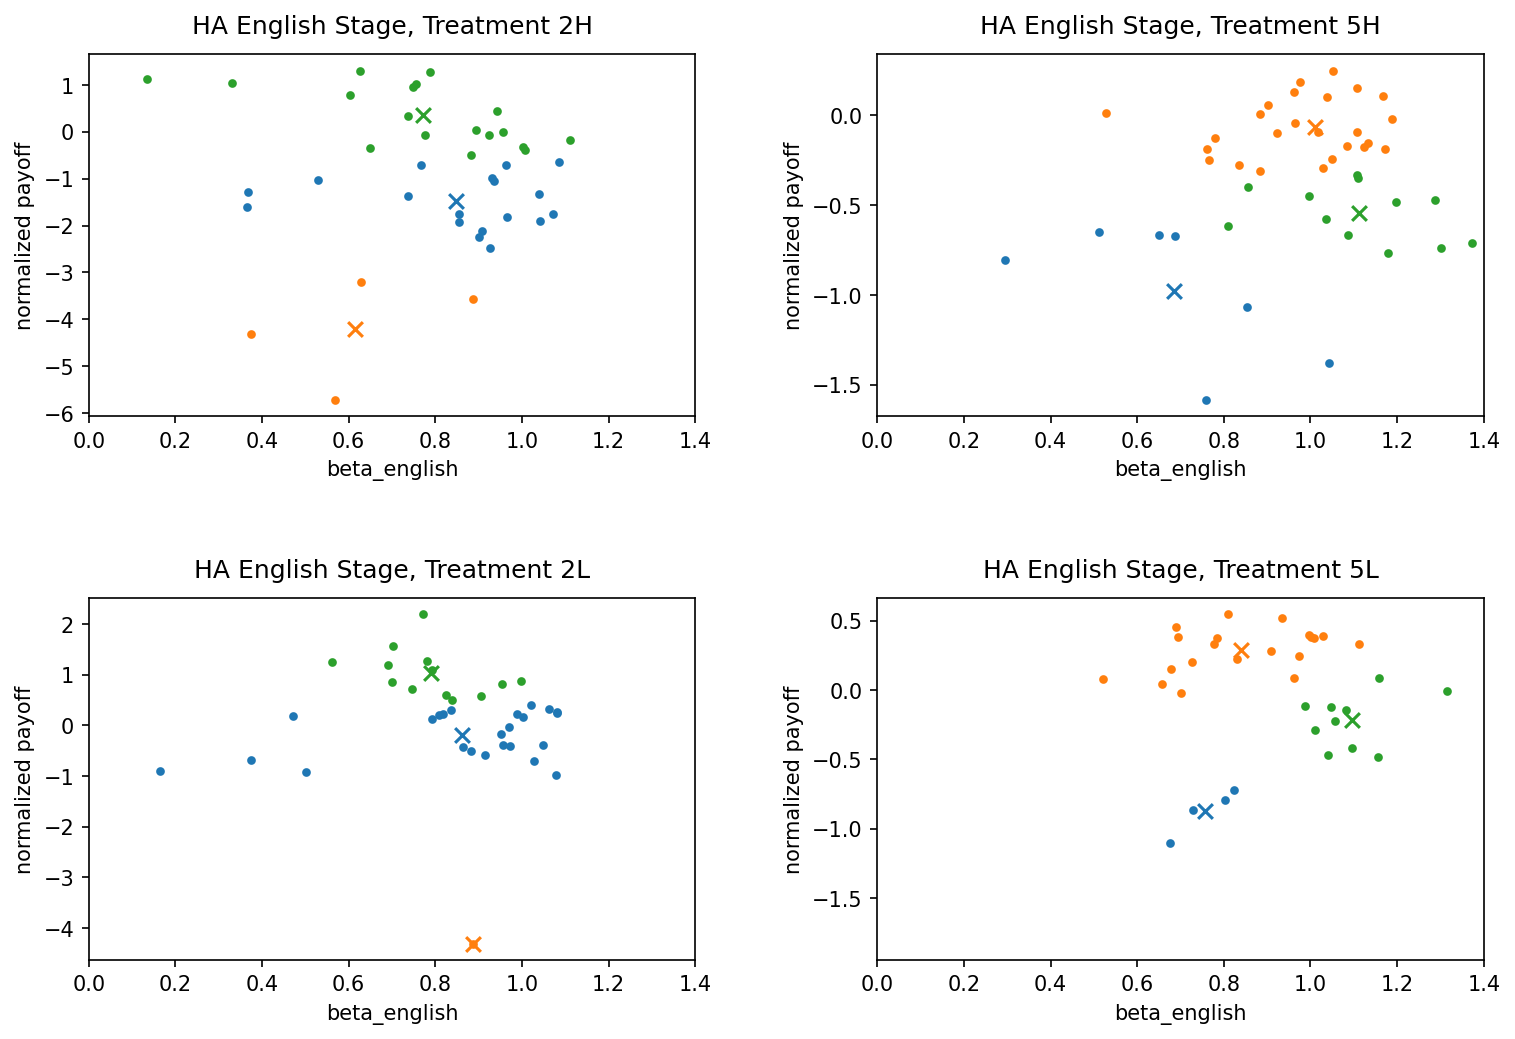

In [142]:
plt.figure(figsize=(12, 8), dpi=150)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.subplot(221)
plotCluster(2, 0.019, 3)
plt.subplot(223)
plotCluster(2, 0.009, 3)
plt.subplot(222)
plotCluster(5, 0.019, 3)
plt.subplot(224)
plotCluster(5, 0.009, 4)

##### Normalised Payoff Distribution

In [13]:
def plotPaynormDist(n, b):
    tmpdf = copy.deepcopy(df_cluster[(df_cluster["n"] == n) & (df_cluster["b"] == b)])
    if n == 2:
        if b == 0.019:
            tmpdf["paydiff_norm"] /= 5.88
        elif b == 0.009:
            tmpdf["paydiff_norm"] /= 7.26
    elif n == 5:
        if b == 0.019:
            tmpdf["paydiff_norm"] /= 1.265
        elif b == 0.009:
            tmpdf["paydiff_norm"] /= 1.445
    sns.histplot(tmpdf["paydiff_norm"], bins=np.arange(-1.3, 0.5, 0.1), stat="density")
    plt.xlabel("actual/theoretical ratio")
    plt.ylim(0, 3.5)
    plt.title(str(n) + ("H" if b == 0.019 else "L"))

Text(0.5, 0.98, 'Distribution of normalised payoffs')

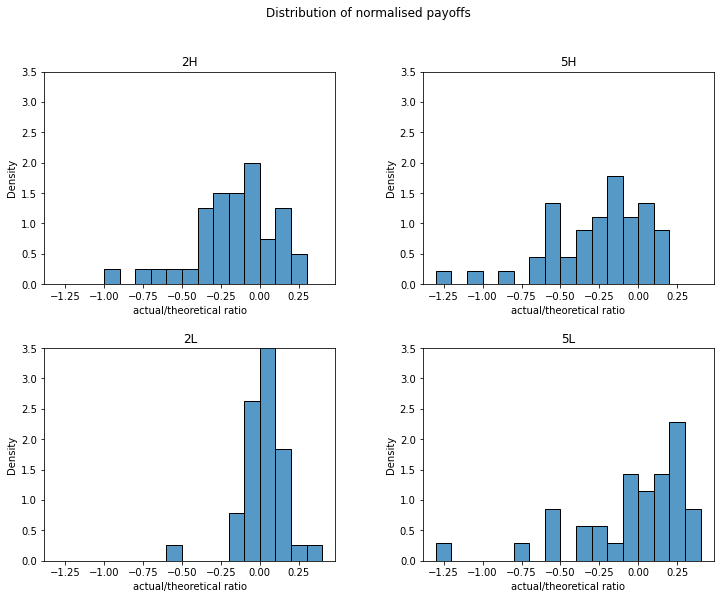

In [14]:
plt.figure(figsize=(12, 9))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(2, 2, 1)
plotPaynormDist(2, 0.019)
plt.subplot(2, 2, 3)
plotPaynormDist(2, 0.009)
plt.subplot(2, 2, 2)
plotPaynormDist(5, 0.019)
plt.subplot(2, 2, 4)
plotPaynormDist(5, 0.009)
plt.suptitle("Distribution of normalised payoffs")

In [14]:
def plotPaypctDist(n, b):
    tmpdf_h = copy.deepcopy(df_h_cluster[(df_h_cluster["n"] == n) & (df_h_cluster["b"] == b)])
    tmpdf_d = copy.deepcopy(df_d_cluster[(df_d_cluster["n"] == n) & (df_d_cluster["b"] == b)])
    
    sns.histplot(np.clip(tmpdf_h["paydiff_pct"], -0.1, 2.1), bins=np.arange(-0.1, 2.2, 0.1), color="C0", edgecolor=None, alpha=0.4, stat="probability", label="Honolulu") 
    all_median = np.quantile(tmpdf_h["paydiff_pct"], 0.5)
    bottom_average = np.average(tmpdf_h[(tmpdf_h["paydiff_pct"] <= all_median) & (tmpdf_h["paydiff_pct"] >= 0)]["paydiff_pct"])
    top_average = np.average(tmpdf_h[(tmpdf_h["paydiff_pct"] > all_median) & (tmpdf_h["paydiff_pct"] <= 2)]["paydiff_pct"])
    plt.axvline(all_median, color="C0", linestyle="--", linewidth=1, label="Honolulu bottom/top cutoff")
    plt.scatter([bottom_average, top_average], [0.01, 0.01], color="C0", marker="$\\downarrow$", s=80, label="Honolulu bottom/top average")
    plt.annotate("Honolulu:\ncutoff = {:.1%}\nbottom average = {:.1%}\ntop average = {:.1%}".format(all_median, bottom_average, top_average), xy=(1.3, 0.4), xytext=(1.3, 0.3), color="C0")

    sns.histplot(np.clip(tmpdf_d["paydiff_pct"], -0.1, 2.1), bins=np.arange(-0.1, 2.2, 0.1), color="C3", element="step", fill=False, stat="probability", label="Dutch")
    all_median = np.quantile(tmpdf_d["paydiff_pct"], 0.5)
    bottom_average = np.average(tmpdf_d[(tmpdf_d["paydiff_pct"] <= all_median) & (tmpdf_d["paydiff_pct"] >= 0)]["paydiff_pct"])
    top_average = np.average(tmpdf_d[(tmpdf_d["paydiff_pct"] > all_median) & (tmpdf_d["paydiff_pct"] <= 2)]["paydiff_pct"])
    plt.axvline(all_median, color="C3", linestyle="-.", linewidth=1, label="Dutch bottom/top cutoff")
    plt.scatter([bottom_average, top_average], [0.01, 0.01], color="C3", marker="$\\twoheaddownarrow$", s=80, label="Dutch bottom/top average")
    plt.annotate("Dutch:\ncutoff = {:.1%}\nbottom average = {:.1%}\ntop average = {:.1%}".format(all_median, bottom_average, top_average), xy=(1.3, 0.4), xytext=(1.3, 0.2), color="C3")

    plt.xticks(ticks=[0, 0.5, 1, 1.5, 2], labels=["$\\leq0\\%$", "$50\\%$", "$100\\%$", "$150\\%$", "$\\geq200\\%$"])
    plt.xlabel("percent payoff")
    plt.ylim(0, 0.40)
    plt.title(str(n) + ("H" if b == 0.019 else "L"))

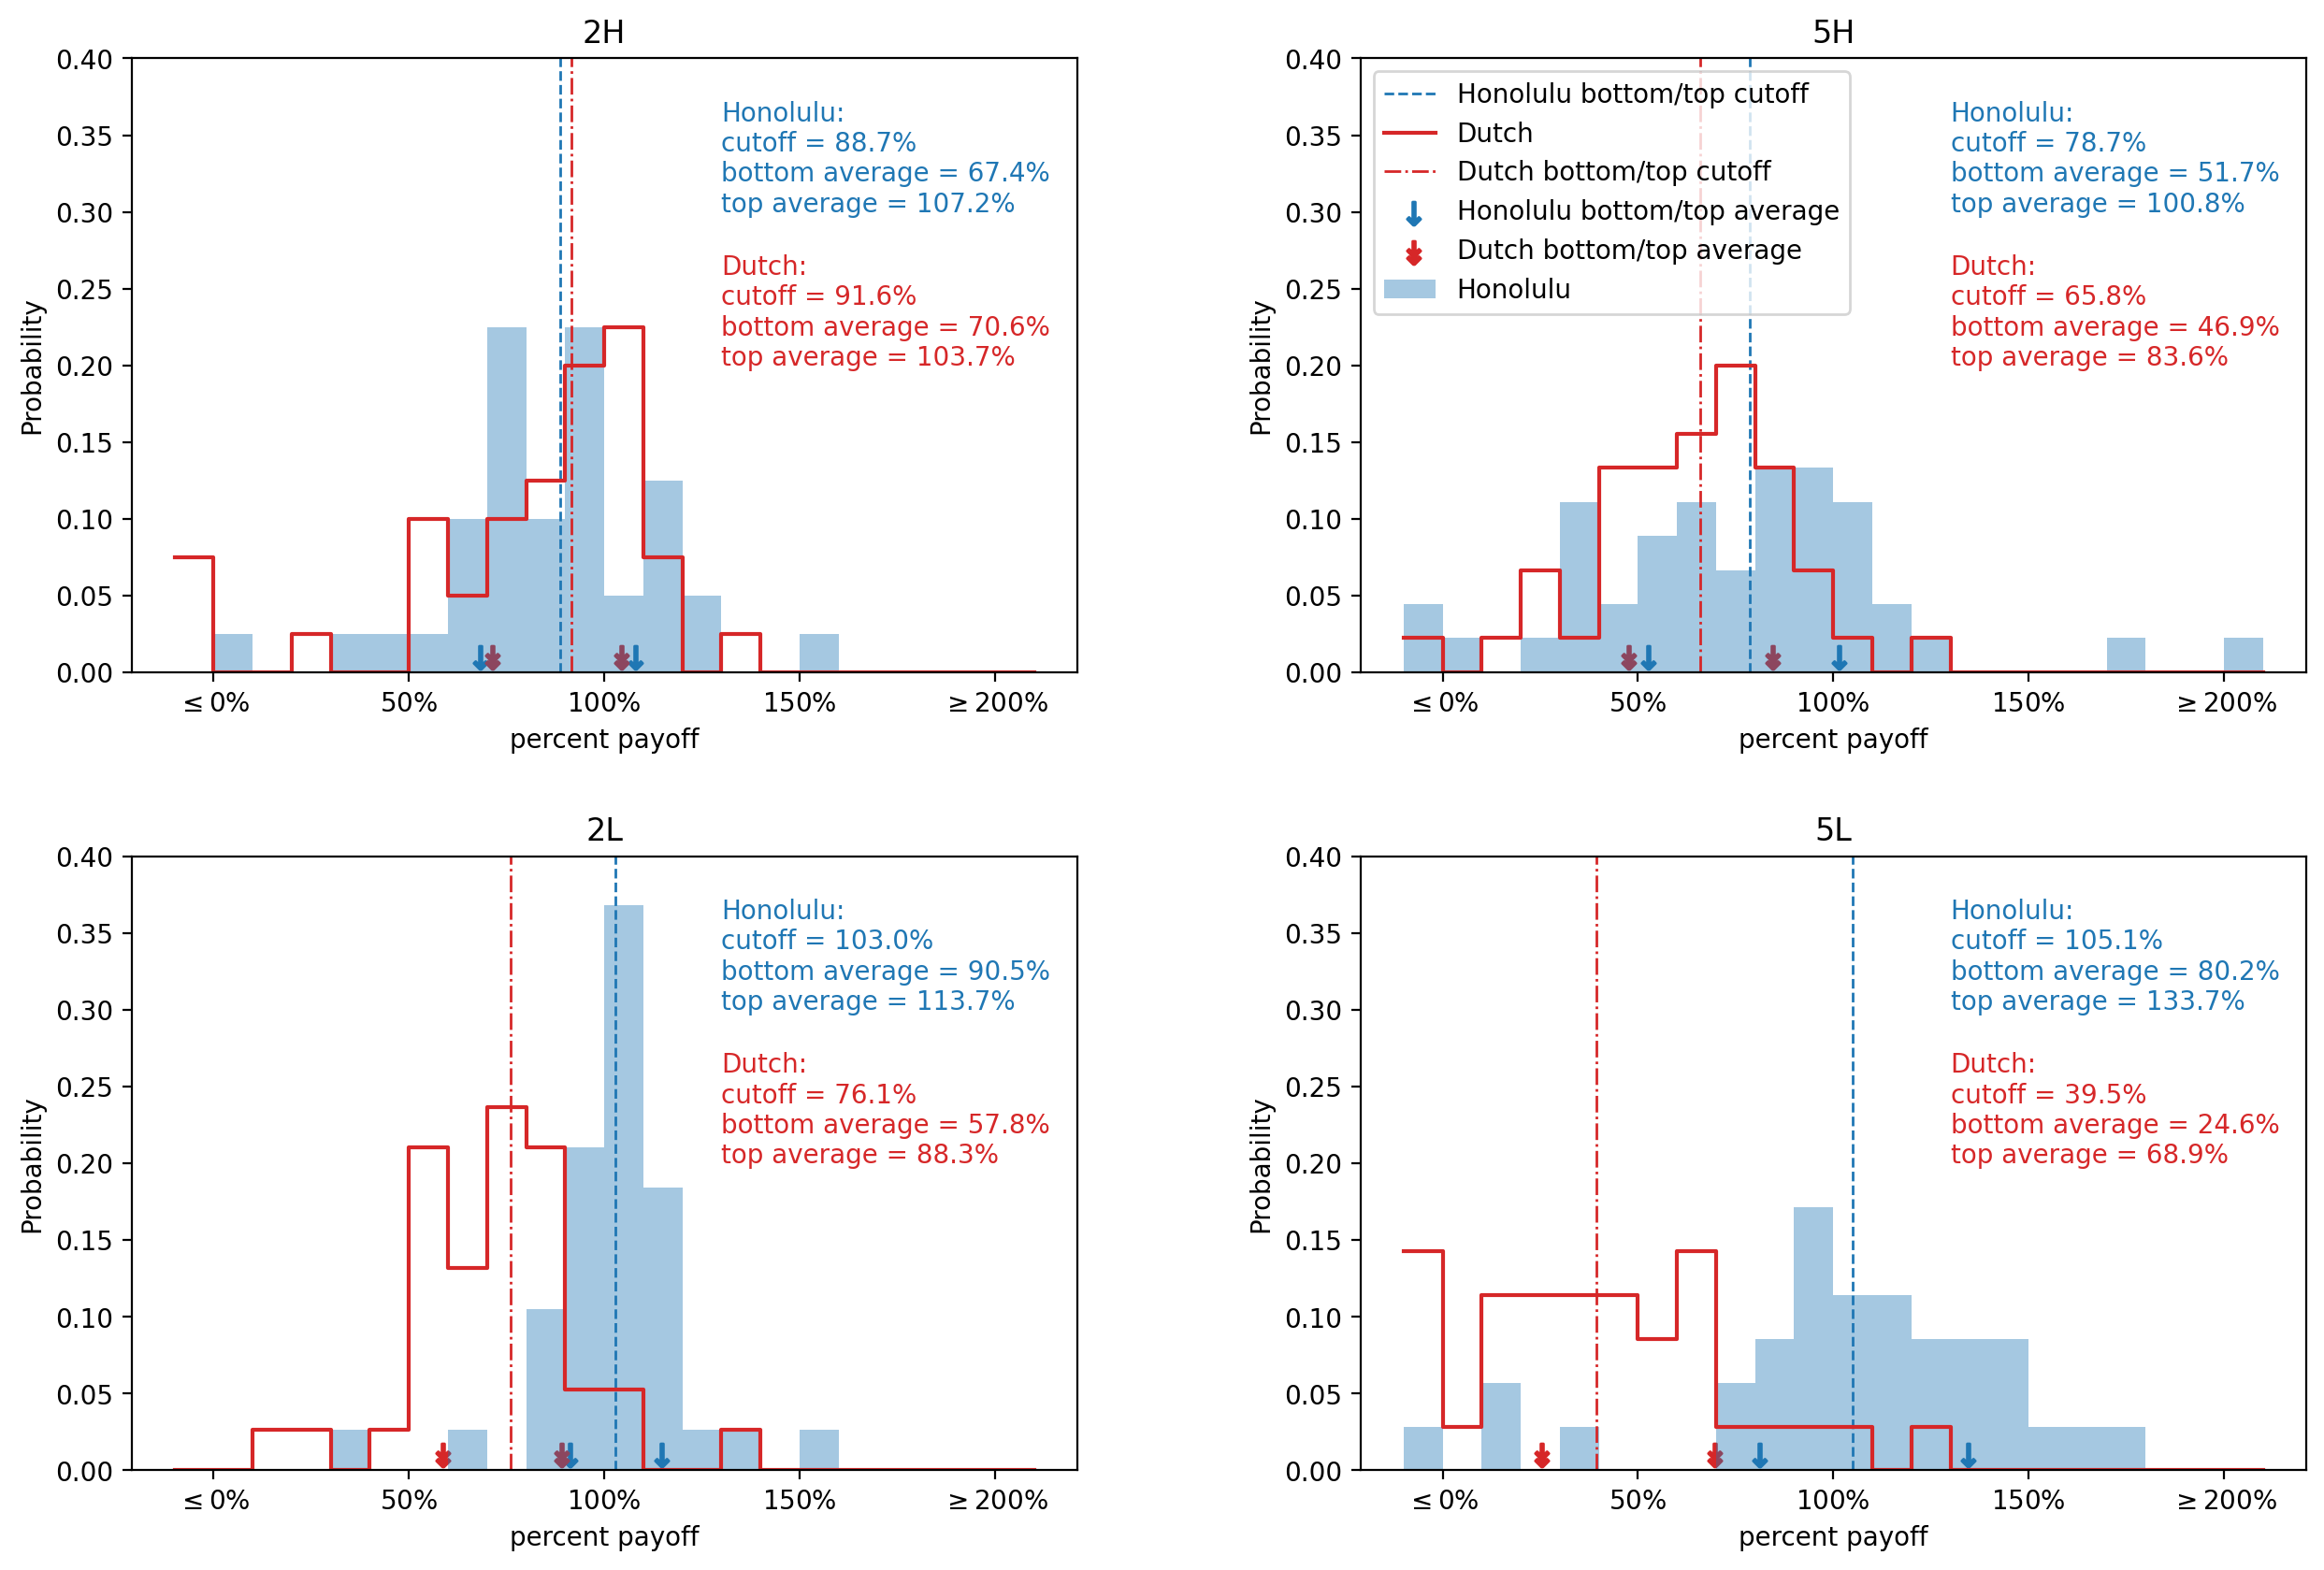

In [15]:
plt.figure(figsize=(15, 10), dpi=200)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(2, 2, 1)
plotPaypctDist(2, 0.019)
plt.subplot(2, 2, 3)
plotPaypctDist(2, 0.009)
plt.subplot(2, 2, 2)
plotPaypctDist(5, 0.019)
plt.legend(loc="upper left")
plt.subplot(2, 2, 4)
plotPaypctDist(5, 0.009)

#### DA Dutch

In [ ]:
def dDutchPlot(n, b):
    tmp1, tmp2, tmp3, tmp4, tmp5 = [], [], [], [], []
    for key in dict_all.keys():
        if (str(n) + "_" in dict_all[key]["session_name"]) and (dict_all[key]["discount"] == b):
            rank = dict_all[key]["d_dutch_winner_value_rank"]
            exec("tmp%d.append(dict_all[key]['d_dutch_final_price'] - dict_all[key]['d_dutch_winner_optimal_bid'])" % rank)
    plt.boxplot([tmp1, tmp2, tmp3, tmp4, tmp5], notch=True, showmeans=True)
    plt.xlabel("winner item value rank")
    plt.ylabel("actual - predict")
    plt.ylim(-25, 50)
    plt.title("n=%d, b=%.3f, obs=%s" % (n, b, (len(tmp1), len(tmp2), len(tmp3), len(tmp4), len(tmp5))))

Text(0.5, 0.98, "DA winner's deviation from theoretical optimal bid")

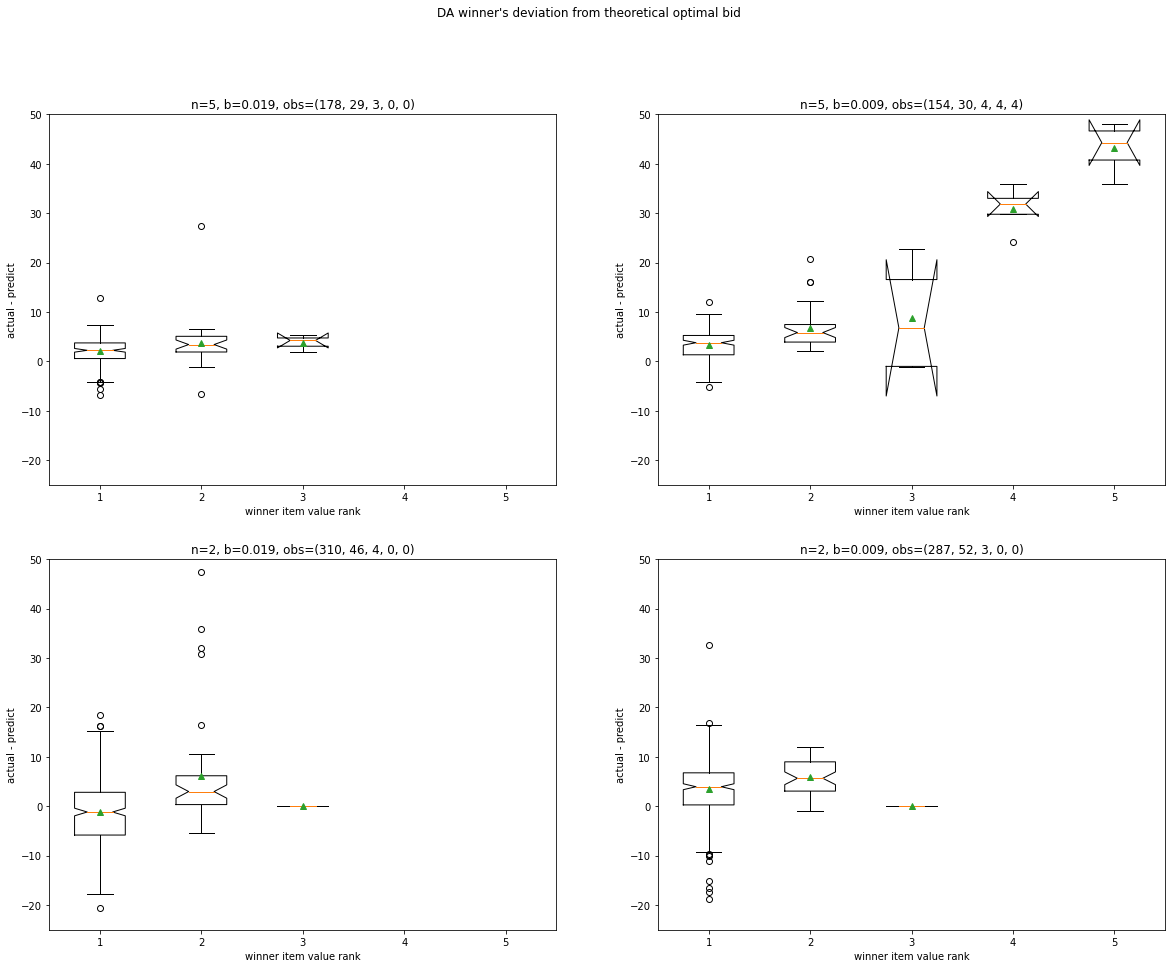

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.subplot(2, 2, 1)
dDutchPlot(5, 0.019)
plt.subplot(2, 2, 2)
dDutchPlot(5, 0.009)
plt.subplot(2, 2, 3)
dDutchPlot(2, 0.019)
plt.subplot(2, 2, 4)
dDutchPlot(2, 0.009)
plt.suptitle("DA winner's deviation from theoretical optimal bid")

In [ ]:
def dDutchPlot2(n, b, list_rank):
    tmpx_all, tmpy_all = [], []
    for rank in list_rank:
        tmpx, tmpy = [], []
        for key in dict_all.keys():
            if (str(n) + "_" in dict_all[key]["session_name"]) and (dict_all[key]["discount"] == b) and (dict_all[key]["d_dutch_winner_value_rank"] == rank):
                tmpx_all.append(dict_all[key]["d_dutch_winner_item_value"])
                tmpx.append(dict_all[key]["d_dutch_winner_item_value"])
                tmpy_all.append(dict_all[key]['d_dutch_winner_optimal_bid'])
                tmpy.append(dict_all[key]['d_dutch_final_price'])
        plt.scatter(tmpx, tmpy, marker="o", s=40/rank, label="rank_"+str(rank))
    plt.axline((0, 0), (50, 50), color="black")
    plt.scatter(tmpx_all, tmpy_all, marker="_", color="orange", label="optimal bid")
    plt.axline((0, 0), (50, 50 * (n - 1) / n), color="green", label="zero-cost prediction")
    plt.xlabel("item value (predicted leave price)")
    plt.ylabel("actual leave price")
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.legend()
    plt.title("n=%d, b=%.3f" % (n, b))

Text(0.5, 0.98, 'DA bid for different rank of item value')

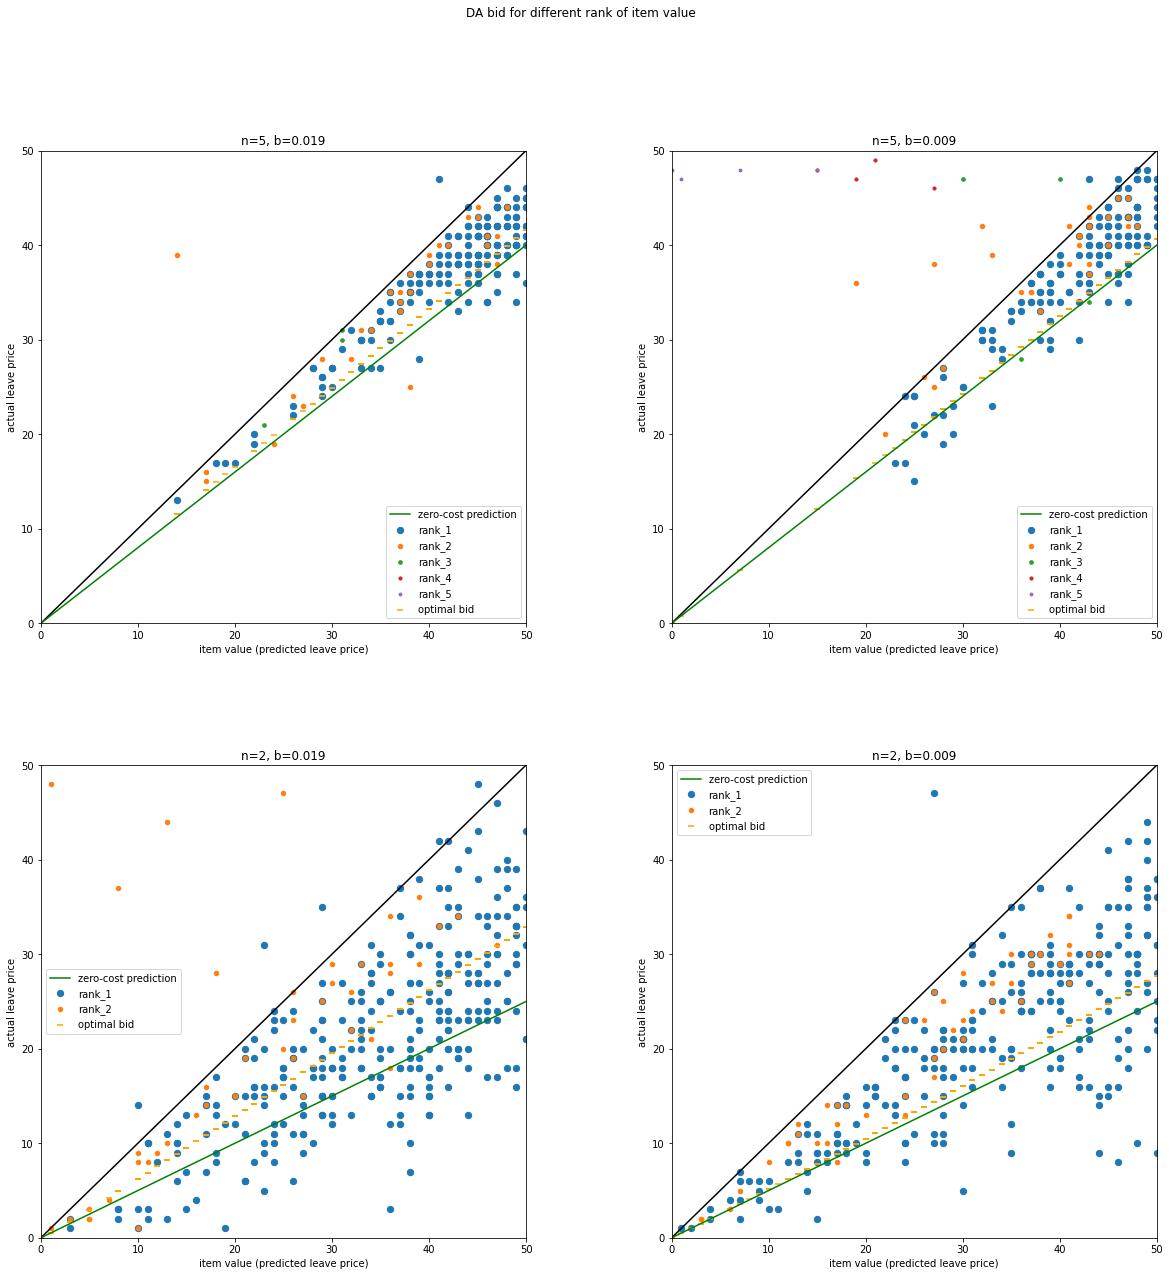

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(2, 2, 1)
dDutchPlot2(5, 0.019, [1, 2, 3, 4, 5])
plt.subplot(2, 2, 2)
dDutchPlot2(5, 0.009, [1, 2, 3, 4, 5])
plt.subplot(2, 2, 3)
dDutchPlot2(2, 0.019, [1, 2])
plt.subplot(2, 2, 4)
dDutchPlot2(2, 0.009, [1, 2])
plt.suptitle("DA bid for different rank of item value")

#### HA Dutch

In [ ]:
def hDutchPlot(n, b):
    tmp1, tmp2, tmp3, tmp4, tmp5 = [], [], [], [], []
    for key in dict_all.keys():
        if (str(n) + "_" in dict_all[key]["session_name"]) and (dict_all[key]["discount"] == b):
            rank = dict_all[key]["h_dutch_winner_value_rank"]
            exec("tmp%d.append(dict_all[key]['h_dutch_final_price'] - dict_all[key]['h_dutch_winner_optimal_bid'])" % rank)
    plt.boxplot([tmp1, tmp2, tmp3, tmp4, tmp5], notch=True, showmeans=True)
    plt.xlabel("winner item value rank")
    plt.ylabel("actual  - predict")
    plt.ylim(25, -50)
    plt.title("n=%d, b=%.3f, obs=%s" % (n, b, (len(tmp1), len(tmp2), len(tmp3), len(tmp4), len(tmp5))))

Text(0.5, 0.98, "HA Dutch stage winner's deviation from theoretical optimal bid")

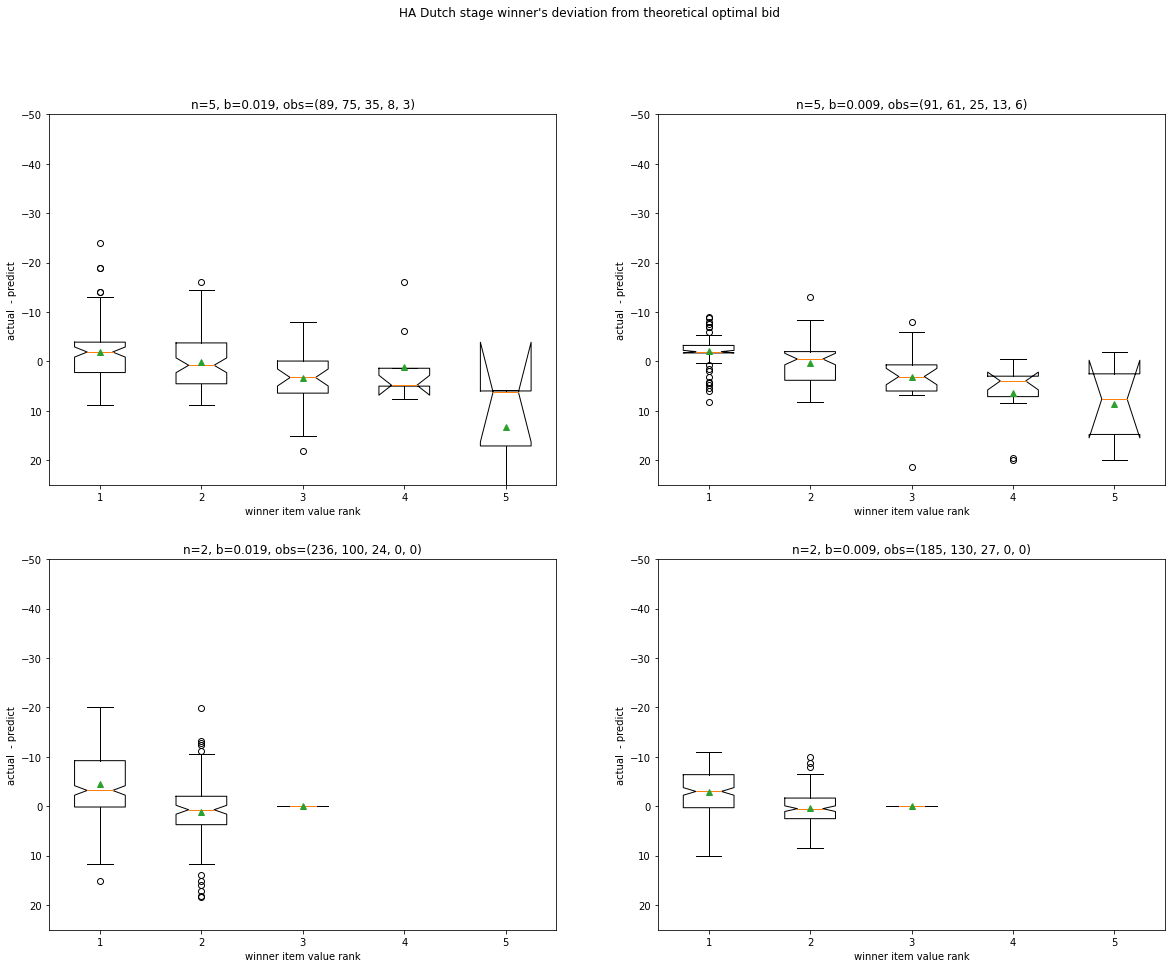

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.subplot(2, 2, 1)
hDutchPlot(5, 0.019)
plt.subplot(2, 2, 2)
hDutchPlot(5, 0.009)
plt.subplot(2, 2, 3)
hDutchPlot(2, 0.019)
plt.subplot(2, 2, 4)
hDutchPlot(2, 0.009)
plt.suptitle("HA Dutch stage winner's deviation from theoretical optimal bid")

In [ ]:
def hDutchPlot2(n, b, list_rank):
    tmpx_all, tmpy_all = [], []
    for rank in list_rank:
        tmpx, tmpy = [], []
        for key in dict_all.keys():
            if (str(n) + "_" in dict_all[key]["session_name"]) and (dict_all[key]["discount"] == b) and (dict_all[key]["h_dutch_winner_value_rank"] == rank):
                tmpx_all.append(dict_all[key]["h_dutch_winner_item_value"])
                tmpx.append(dict_all[key]["h_dutch_winner_item_value"])
                tmpy_all.append(dict_all[key]['h_dutch_winner_optimal_bid'])
                tmpy.append(dict_all[key]['h_dutch_final_price'])
        plt.scatter(tmpx, tmpy, marker="o", s=40/rank, label="rank_"+str(rank))
    plt.axline((0, 0), (50, 50), color="black")
    plt.scatter(tmpx_all, tmpy_all, marker="_", color="green", label="optimal bid")
    plt.xlabel("item value")
    plt.ylabel("actual leave price")
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.legend()
    plt.title("n=%d, b=%.3f" % (n, b))

Text(0.5, 0.98, 'HA Dutch stage bid for different rank of item value')

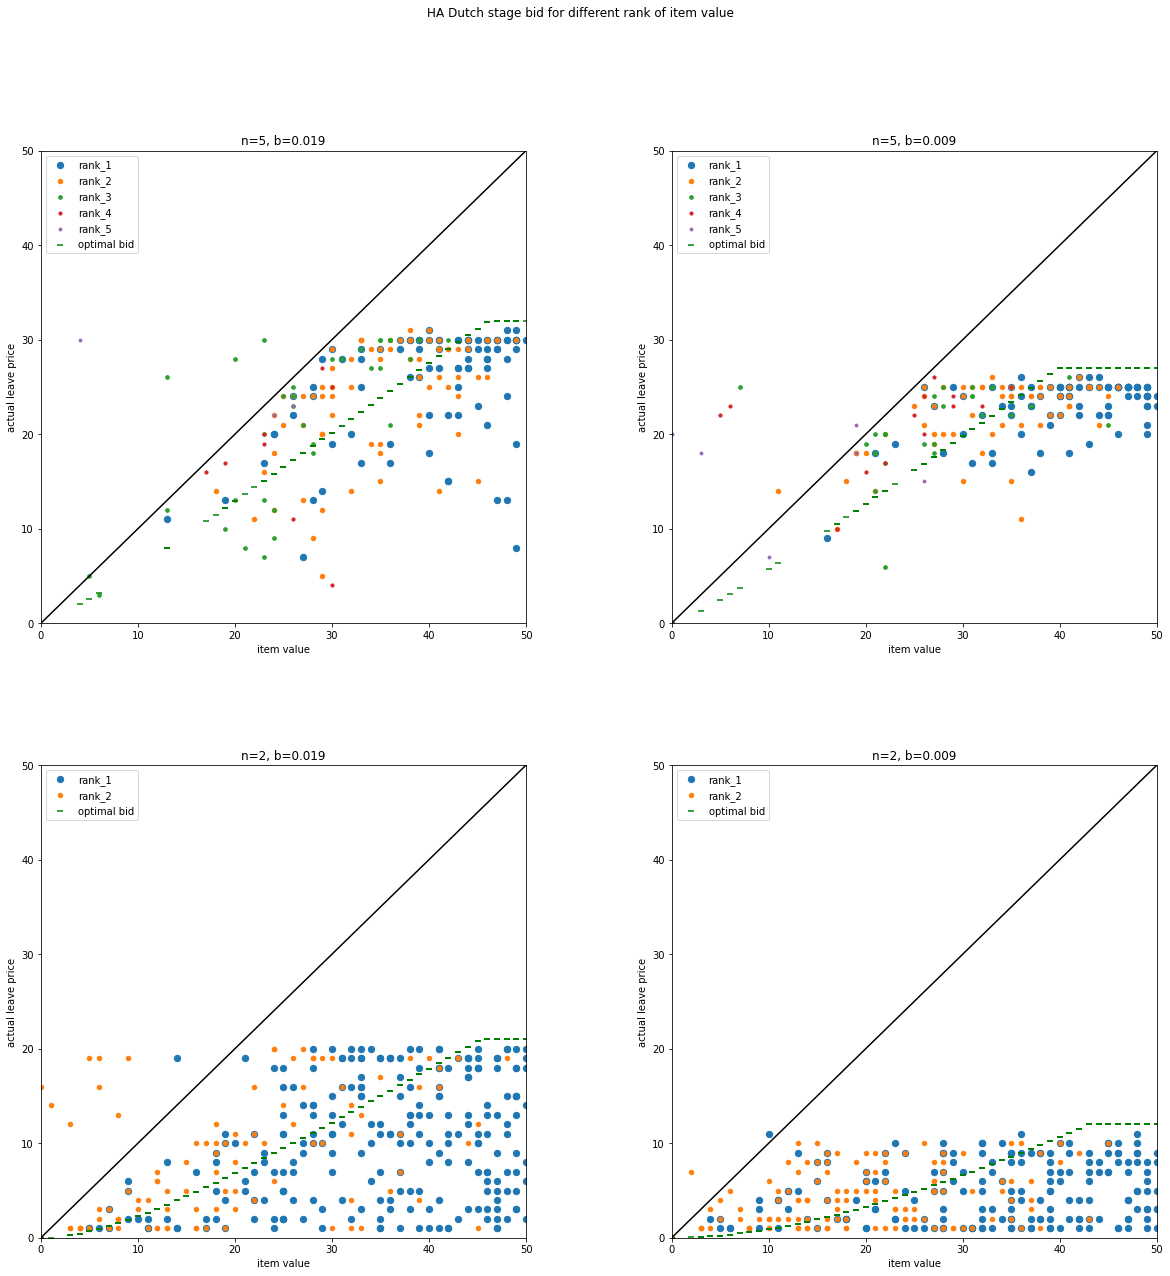

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(2, 2, 1)
hDutchPlot2(5, 0.019, [1, 2, 3, 4, 5])
plt.subplot(2, 2, 2)
hDutchPlot2(5, 0.009, [1, 2, 3, 4, 5])
plt.subplot(2, 2, 3)
hDutchPlot2(2, 0.019, [1, 2])
plt.subplot(2, 2, 4)
hDutchPlot2(2, 0.009, [1, 2])
plt.suptitle("HA Dutch stage bid for different rank of item value")

#### HA Contest Leave

In [ ]:
def hContestPlot(n, b):
    tmp0, tmp1, tmp2, tmp3, tmp4, tmp5 = [], [], [], [], [], []
    for key in dict_all.keys():
        if (str(n) + "_" in dict_all[key]["session_name"]) and (dict_all[key]["discount"] == b):
            n_player = dict_all[key]["h_english_num_player"]
            exec("tmp%d.extend(np.array(dict_all[key]['h_contest_leave_item_value']) - np.array(dict_all[key]['h_dutch_final_price']))" % n_player)
    plt.boxplot([tmp0, tmp1, tmp2, tmp3, tmp4, tmp5], notch=True, showmeans=True, positions=[0, 1, 2, 3, 4, 5])
    plt.xlabel("number of contestants")
    plt.ylabel("actual - predict")
    plt.ylim(-35, 45)
    plt.title("n=%d, b=%.3f, obs=%s" % (n, b, (len(tmp0), len(tmp1), len(tmp2), len(tmp3), len(tmp4), len(tmp5))))

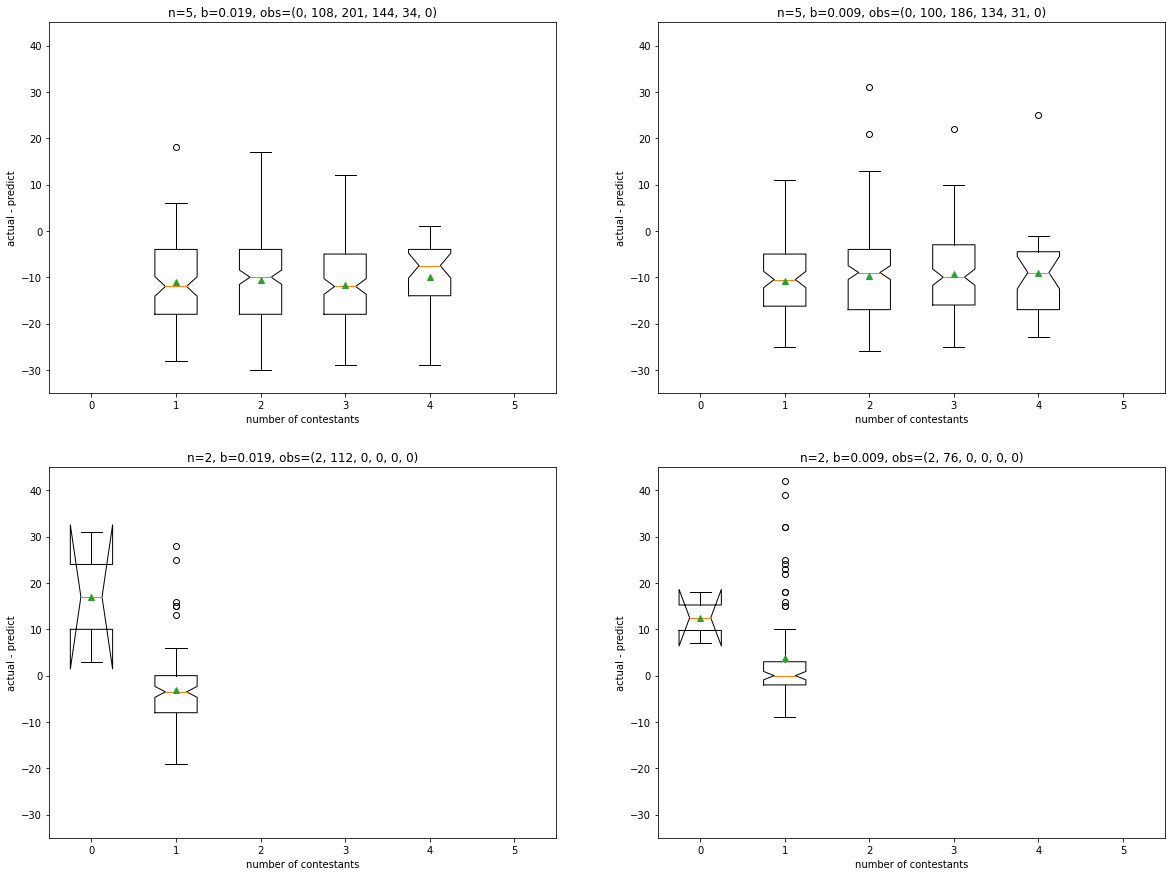

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.subplot(2, 2, 1)
hContestPlot(5, 0.019)
plt.subplot(2, 2, 2)
hContestPlot(5, 0.009)
plt.subplot(2, 2, 3)
hContestPlot(2, 0.019)
plt.subplot(2, 2, 4)
hContestPlot(2, 0.009)

In [ ]:
def hContestPlot2(n, b, list_n_player):
    m_list = ["o", "s", "D", "+"]
    c_list = ["none", "none", "none", "purple"]
    e_list = ["blue", "darkorange", "green", "purple"]
    s_list = [100, 60, 30, 30]
    for n_player in list_n_player:
        tmpx, tmpy = [], []
        for key in dict_all.keys():
            if (str(n) + "_" in dict_all[key]["session_name"]) and (dict_all[key]["discount"] == b) and (dict_all[key]["h_english_num_player"] == n_player):
                tmpx.extend(dict_all[key]['h_contest_leave_item_value'])
                tmpy.extend(np.ones_like(dict_all[key]['h_contest_leave_item_value']) * dict_all[key]['h_dutch_final_price'])
        plt.scatter(tmpx, tmpy, marker=m_list[n_player-1], c=c_list[n_player-1], edgecolors=e_list[n_player-1], s=s_list[n_player-1], label="contestant_num_"+str(n_player))
    plt.axline((0, 0), (50, 50), color="black", label="predicted")
    plt.xlabel("item value")
    plt.ylabel("contest price")
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.legend()
    plt.title("n=%d, b=%.3f" % (n, b))

C:\Users\MISAKA~1\AppData\Local\Temp/ipykernel_99780/568545725.py:12: UserWarning: You passed a edgecolor/edgecolors ('purple') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(tmpx, tmpy, marker=m_list[n_player-1], c=c_list[n_player-1], edgecolors=e_list[n_player-1], s=s_list[n_player-1], label="contestant_num_"+str(n_player))


Text(0.5, 0.98, 'HA Contest stage leave price for different number of contestants')

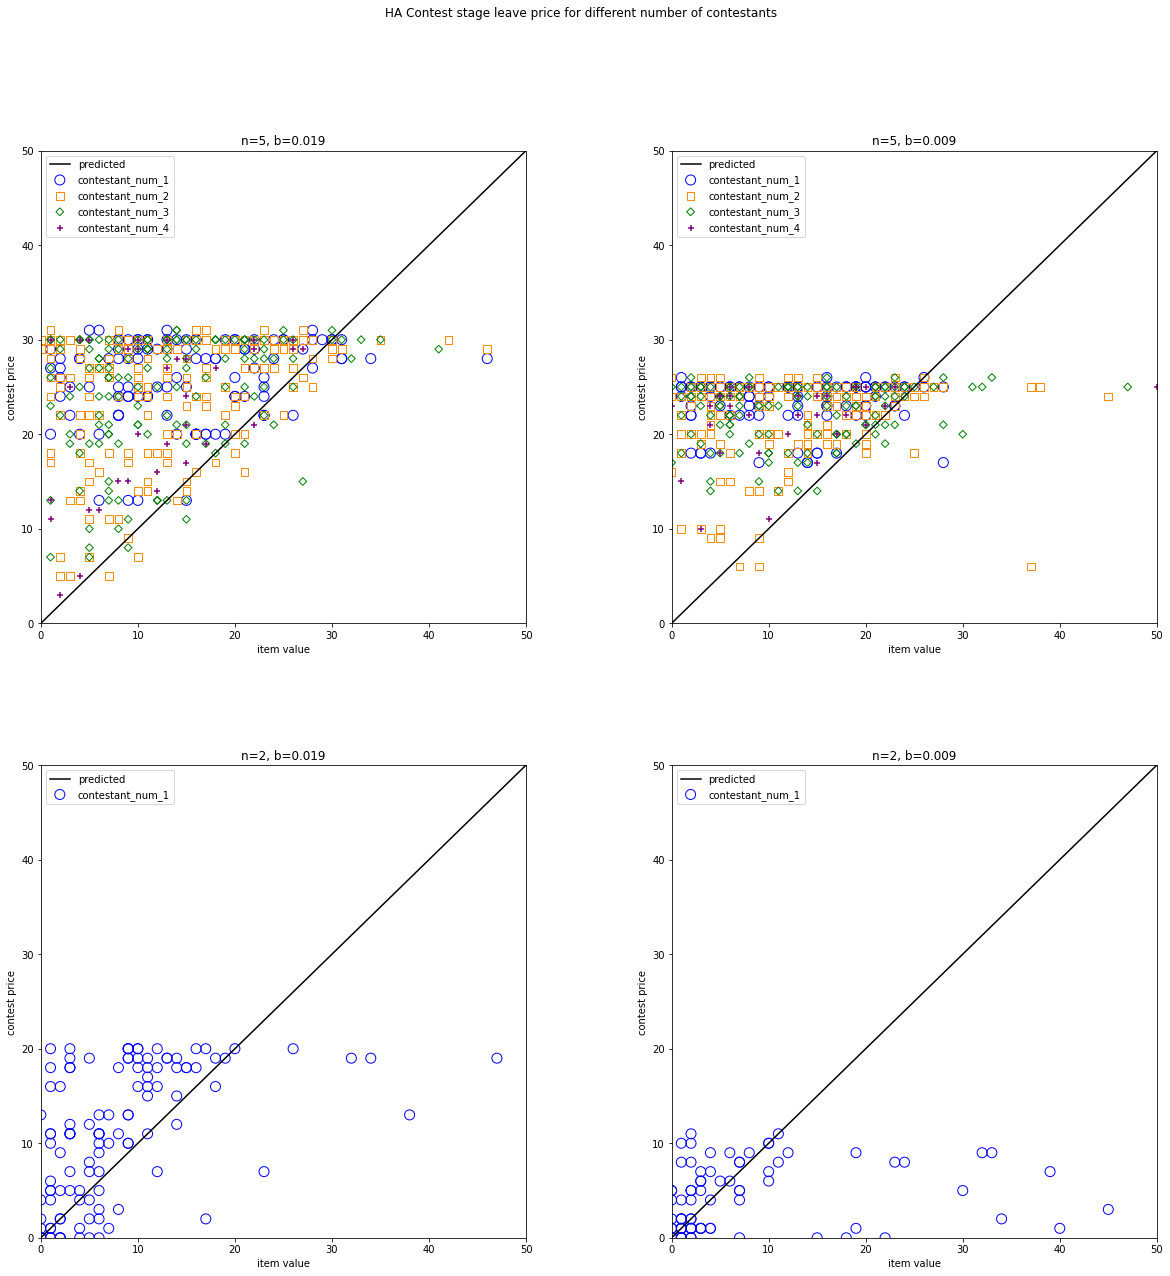

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(2, 2, 1)
hContestPlot2(5, 0.019, [1, 2, 3, 4])
plt.subplot(2, 2, 2)
hContestPlot2(5, 0.009, [1, 2, 3, 4])
plt.subplot(2, 2, 3)
hContestPlot2(2, 0.019, [1])
plt.subplot(2, 2, 4)
hContestPlot2(2, 0.009, [1])
plt.suptitle("HA Contest stage leave price for different number of contestants")

#### HA English

In [ ]:
def hEnglishPlot(n, b):
    tmp0, tmp1, tmp2, tmp3, tmp4, tmp5 = [], [], [], [], [], []
    for key in dict_all.keys():
        if (str(n) + "_" in dict_all[key]["session_name"]) and (dict_all[key]["discount"] == b):
            n_player = dict_all[key]["h_english_num_player"]
            exec("tmp%d.extend(np.array(dict_all[key]['h_english_leave_price']) - np.array(dict_all[key]['h_english_leave_item_value']))" % n_player)
    plt.boxplot([tmp2, tmp3, tmp4, tmp5], notch=True, showmeans=True, positions=[2, 3, 4, 5])
    plt.xlabel("number of contestants")
    plt.ylabel("actual - predict")
    plt.ylim(-40, 40)
    plt.title("n=%d, b=%.3f, obs=%s" % (n, b, (len(tmp2), len(tmp3), len(tmp4), len(tmp5))))

Text(0.5, 0.98, 'HA English stage leave price deviation from theoretical optimal leave')

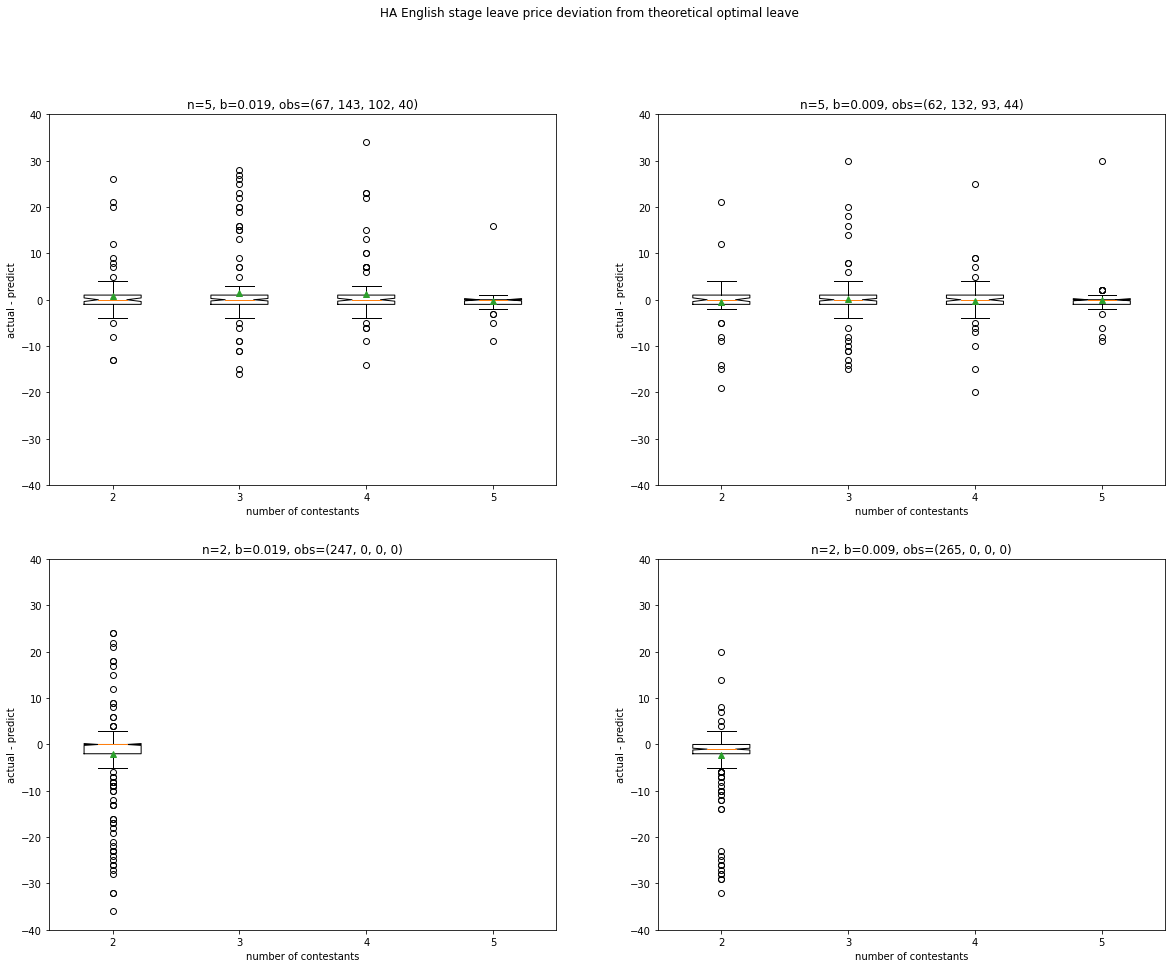

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.subplot(2, 2, 1)
hEnglishPlot(5, 0.019)
plt.subplot(2, 2, 2)
hEnglishPlot(5, 0.009)
plt.subplot(2, 2, 3)
hEnglishPlot(2, 0.019)
plt.subplot(2, 2, 4)
hEnglishPlot(2, 0.009)
plt.suptitle("HA English stage leave price deviation from theoretical optimal leave")

In [ ]:
def hEnglishPlot2(n, b, list_n_player):
    m_list = ["o", "s", "D", "+"]
    c_list = ["none", "none", "none", "purple"]
    e_list = ["blue", "orange", "green", "purple"]
    s_list = [100, 60, 30, 30]
    for n_player in list_n_player:
        tmpx, tmpy = [], []
        for key in dict_all.keys():
            if (str(n) + "_" in dict_all[key]["session_name"]) and (dict_all[key]["discount"] == b) and (dict_all[key]["h_english_num_player"] == n_player):
                tmpx.extend(dict_all[key]['h_english_leave_item_value'])
                tmpy.extend(dict_all[key]['h_english_leave_price'])
        plt.scatter(tmpx, tmpy, marker=m_list[n_player-2], c=c_list[n_player-2], edgecolors=e_list[n_player-2], s=s_list[n_player-2], label="contestant_num_"+str(n_player))
    plt.axline((0, 0), (50, 50), color="black", label="predicted")
    plt.xlabel("item value")
    plt.ylabel("actual leave price")
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.legend()
    plt.title("n=%d, b=%.3f" % (n, b))

C:\Users\MISAKA~1\AppData\Local\Temp/ipykernel_99780/50267429.py:12: UserWarning: You passed a edgecolor/edgecolors ('purple') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(tmpx, tmpy, marker=m_list[n_player-2], c=c_list[n_player-2], edgecolors=e_list[n_player-2], s=s_list[n_player-2], label="contestant_num_"+str(n_player))


Text(0.5, 0.98, 'HA English stage leave price for different number of contestants')

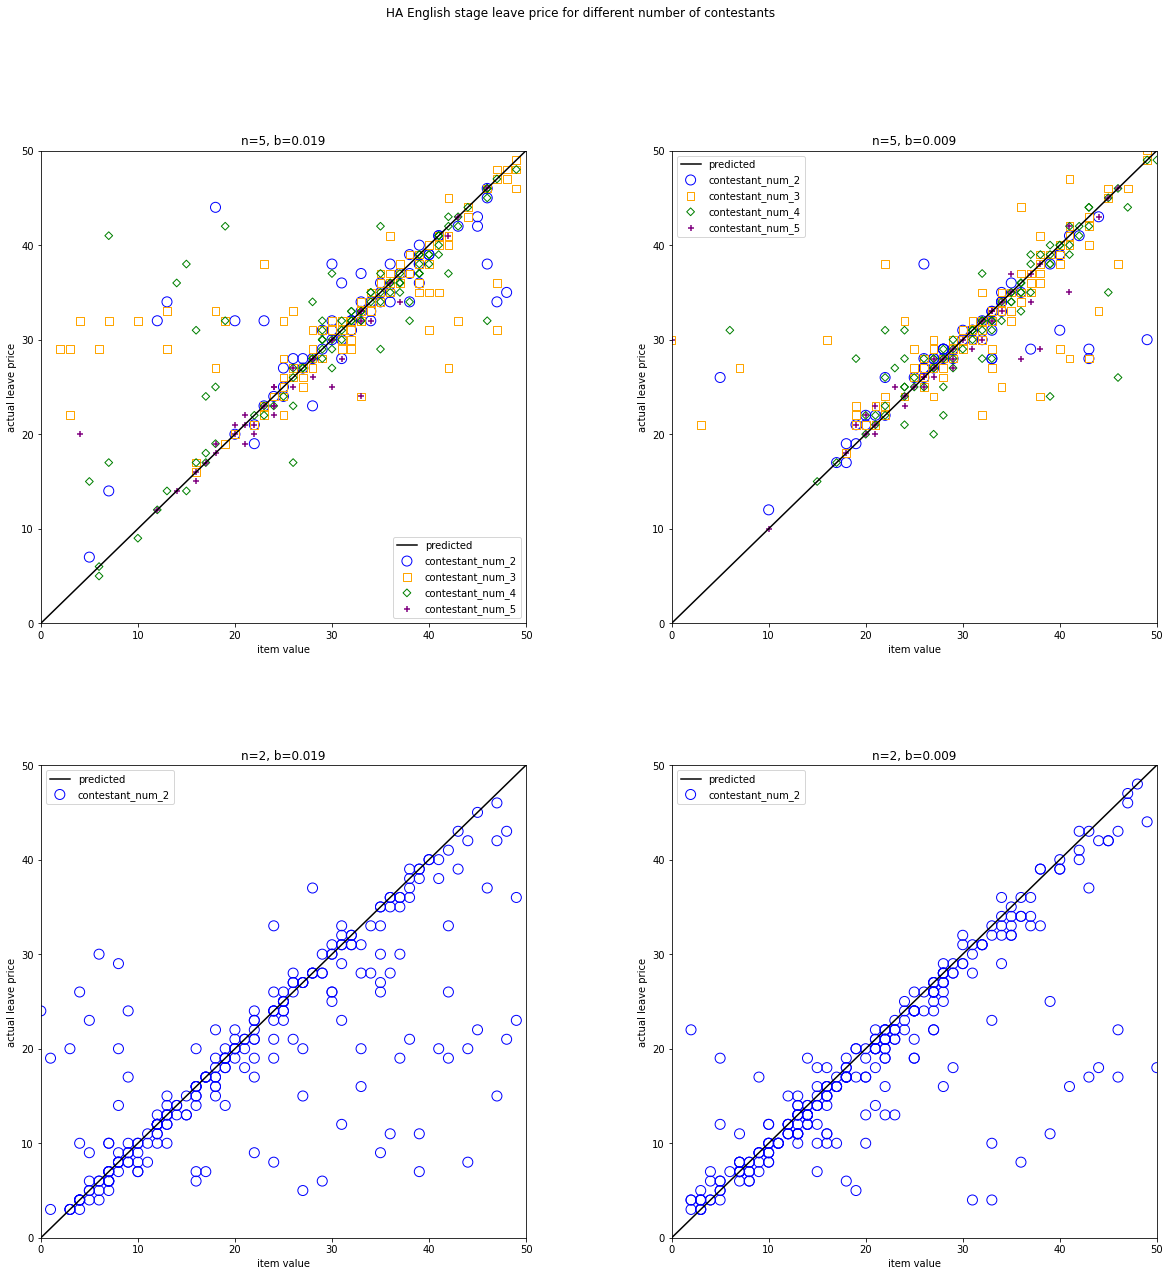

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(2, 2, 1)
hEnglishPlot2(5, 0.019, [2, 3, 4, 5])
plt.subplot(2, 2, 2)
hEnglishPlot2(5, 0.009, [2, 3, 4, 5])
plt.subplot(2, 2, 3)
hEnglishPlot2(2, 0.019, [2])
plt.subplot(2, 2, 4)
hEnglishPlot2(2, 0.009, [2])
plt.suptitle("HA English stage leave price for different number of contestants")

#### Normalised Payoff

In [32]:
def dDutchNormdiffTable(n, b, qmin, qmax):
    mindiff = np.quantile(list(d_dict_paydiff_norm[(n, b)].values()), qmin)
    maxdiff = np.quantile(list(d_dict_paydiff_norm[(n, b)].values()), qmax)
    p_code_list = [k for (k, v) in d_dict_paydiff_norm[(n, b)].items() if (v >= mindiff and v <= maxdiff)]
    tmp = df_d[df_d["participant.code"].isin(p_code_list)]
    tmpx = tmp["player.item_value"].max()
    tmpy = tmp["predict.player.bid"].max()
    tmpx1 = tmp[tmp["player.is_dutch_winner"] == 1]["player.item_value"].tolist()
    tmpy1 = tmp[tmp["player.is_dutch_winner"] == 1]["group.dutch_final_price"].tolist()
    model = LinearRegression(fit_intercept=False)
    model.fit(np.reshape(tmpx1, (-1, 1)), tmpy1)
    return (
        tmpy / tmpx,
        model.coef_[0],
    )

In [ ]:
print("n\tb\toptimal\tq1\tq2\tq3\tq4")
for n in [5, 2]:
    for b in [0.019, 0.009]:
        r0, r1 = dDutchNormdiffTable(n, b, 0.75, 1)
        _, r2 = dDutchNormdiffTable(n, b, 0.5, 0.75)
        _, r3 = dDutchNormdiffTable(n, b, 0.25, 0.5)
        _, r4 = dDutchNormdiffTable(n, b, 0, 0.25) 
        print("%d\t%.3f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f" % (n, b, r0, r1, r2, r3, r4))

n	b	optimal	q1	q2	q3	q4
5	0.019	0.8314	0.8519	0.8779	0.9041	0.9109
5	0.009	0.8134	0.8472	0.9006	0.9068	0.9954
2	0.019	0.6565	0.5839	0.5798	0.6426	0.7459
2	0.009	0.5542	0.6425	0.6273	0.6031	0.7241


In [ ]:
def dDutchNormdiffPlot(n, b, qmin, qmax):
    mindiff = np.quantile(list(d_dict_paydiff_norm[(n, b)].values()), qmin)
    maxdiff = np.quantile(list(d_dict_paydiff_norm[(n, b)].values()), qmax)
    p_code_list = [k for (k, v) in d_dict_paydiff_norm[(n, b)].items() if (v >= mindiff and v <= maxdiff)]
    tmp = df_d[df_d["participant.code"].isin(p_code_list)]
    tmpx = tmp["player.item_value"].sort_values()
    tmpy = tmp["predict.player.bid"].sort_values()
    tmpx1 = tmp[tmp["player.is_dutch_winner"] == 1]["player.item_value"].tolist()
    tmpy1 = tmp[tmp["player.is_dutch_winner"] == 1]["group.dutch_final_price"].tolist()
    model = LinearRegression(fit_intercept=False)
    model.fit(np.reshape(tmpx1, (-1, 1)), tmpy1)
    # tmpx2 = tmp[tmp["player.is_dutch_winner"] == 0]["player.item_value"]
    # tmpy2 = tmp[tmp["player.is_dutch_winner"] == 0]["group.dutch_final_price"]
    plt.axline((0, 0), (50, 50), color="black", linewidth=1, linestyle="--")
    plt.axline((0, 0), (50, 50 * (n - 1) / n), color="purple", linewidth=1, linestyle="--", label="zero-cost prediction")
    plt.plot(tmpx, tmpy, color="green", linewidth=1, label="optimal bid")
    plt.scatter(tmpx1, tmpy1, marker="o", color="none", edgecolor="blue", label="dutch winner")
    plt.axline((0, 0), (50, model.predict([[50]])[0]), color="red", label="reg slope=%.4f"%(model.coef_[0]))
    # plt.scatter(tmpx2, tmpy2, marker="+", color="darkorange", label="not dutch winner")
    plt.xlabel("item value")
    plt.ylabel("dutch bid")
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.legend()
    plt.title("n=%d, b=%.3f, %.2f<=q<=%.2f" % (n, b, qmin, qmax))

Text(0.5, 0.98, "DA winner's bid for different normalised payoff quantiles")

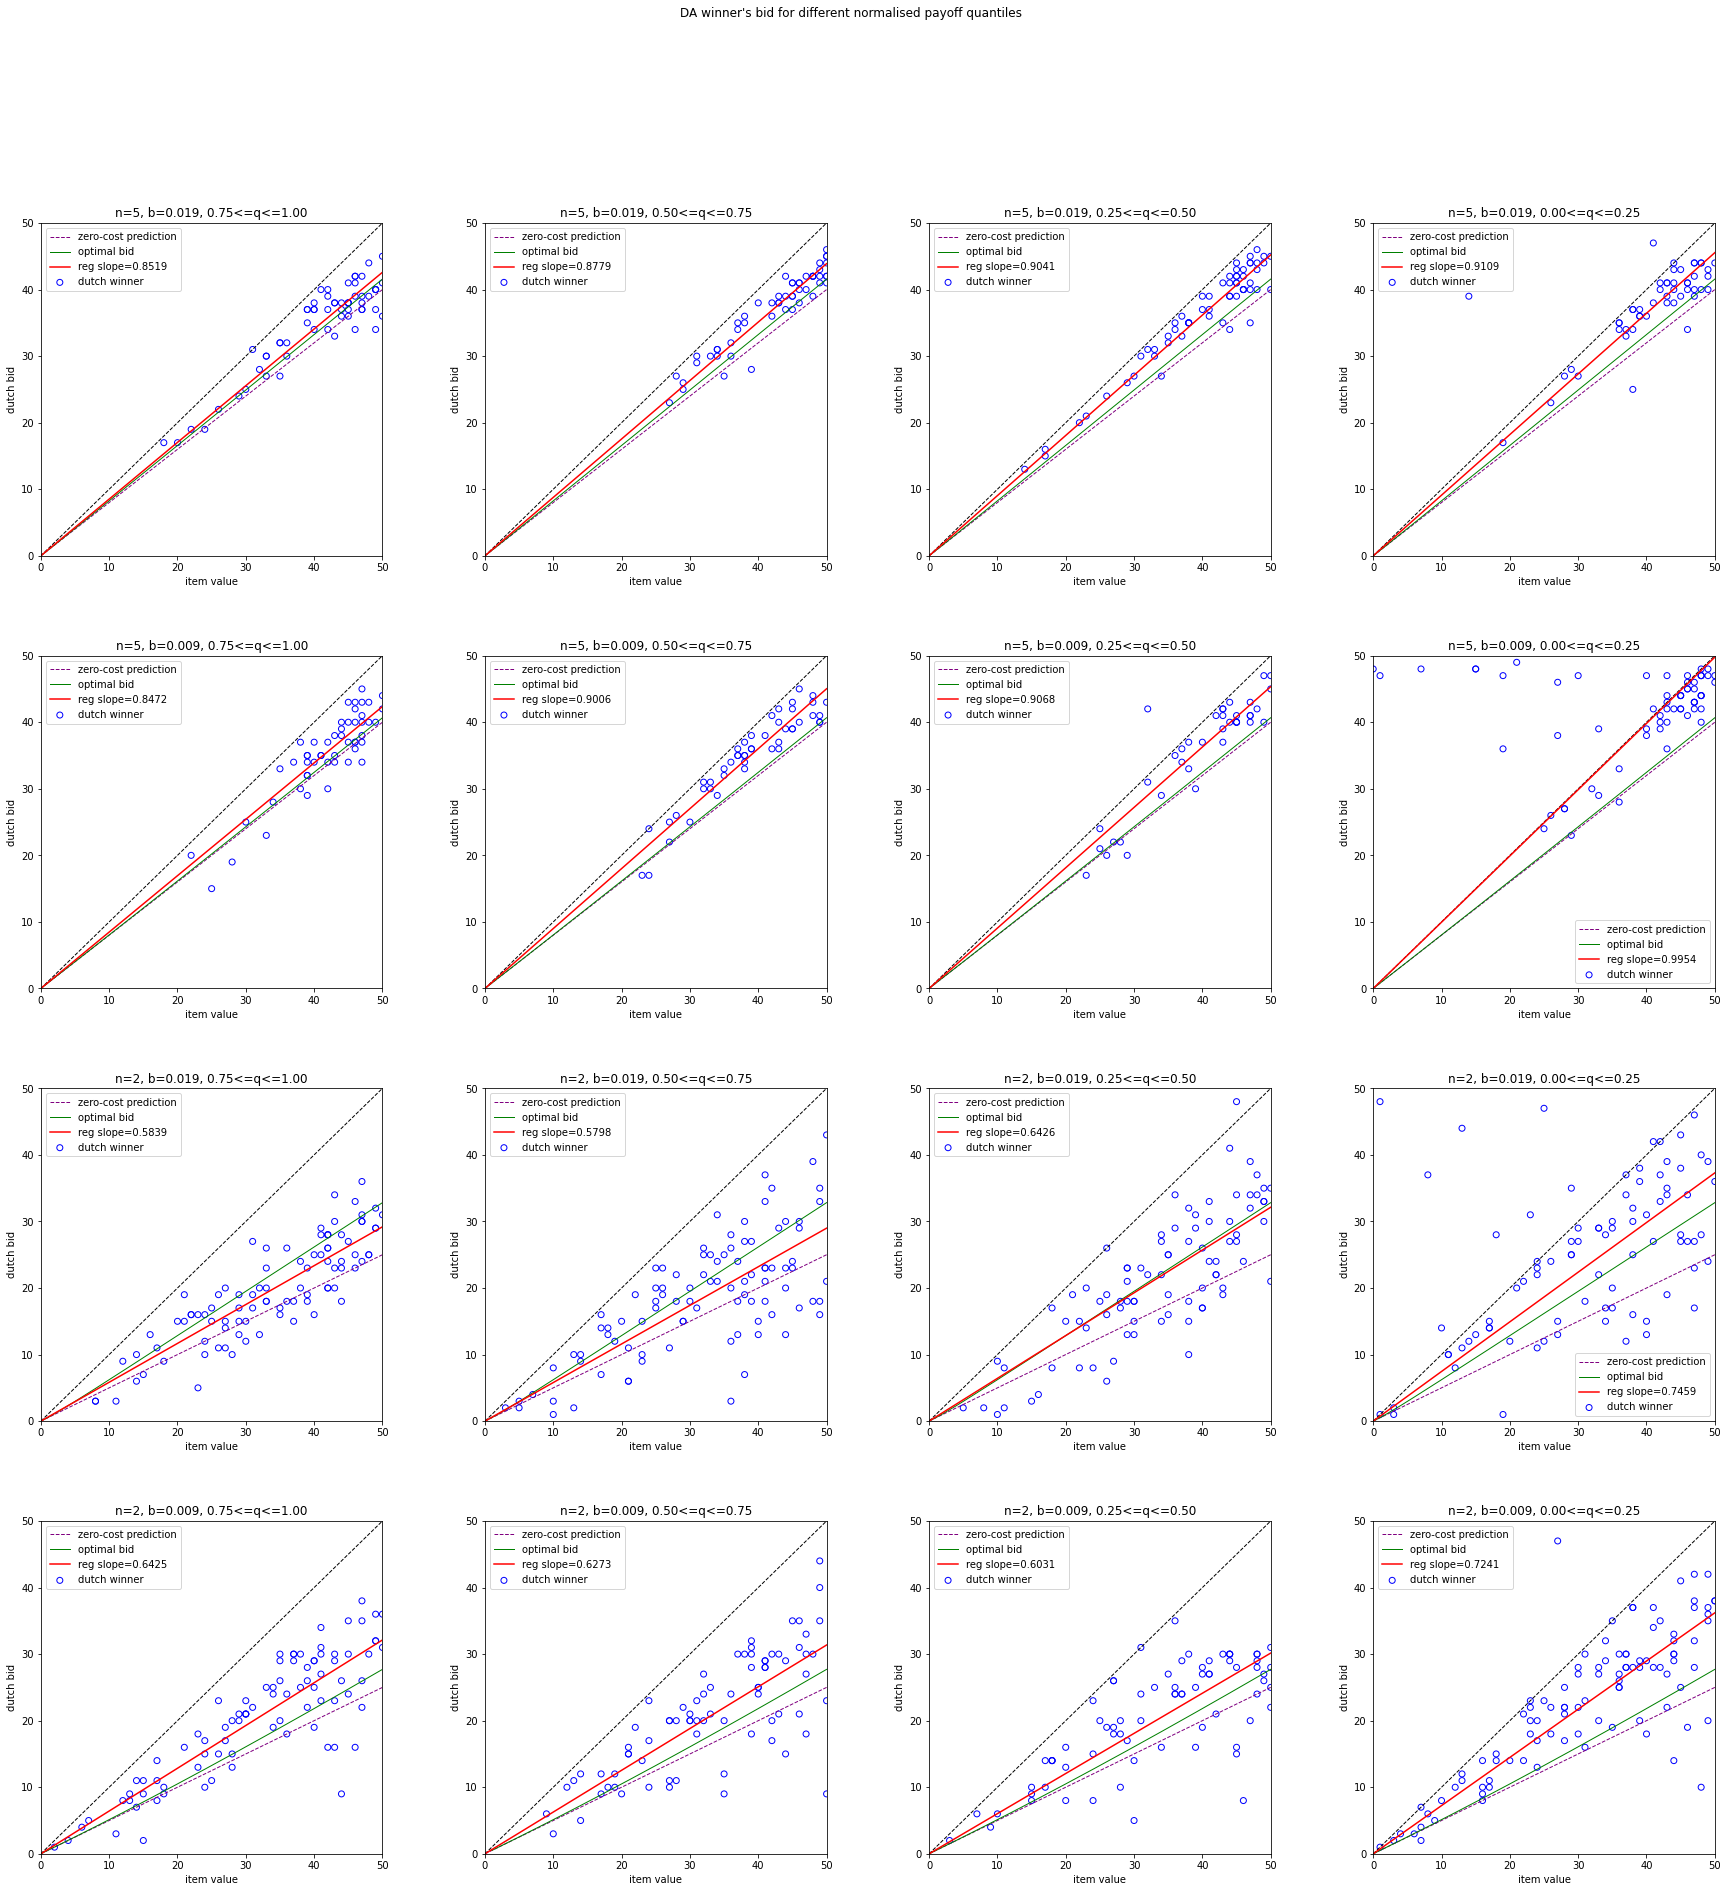

In [ ]:
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(4, 4, 1)
dDutchNormdiffPlot(5, 0.019, 0.75, 1)
plt.subplot(4, 4, 2)
dDutchNormdiffPlot(5, 0.019, 0.5, 0.75)
plt.subplot(4, 4, 3)
dDutchNormdiffPlot(5, 0.019, 0.25, 0.5)
plt.subplot(4, 4, 4)
dDutchNormdiffPlot(5, 0.019, 0, 0.25)
plt.subplot(4, 4, 5)
dDutchNormdiffPlot(5, 0.009, 0.75, 1)
plt.subplot(4, 4, 6)
dDutchNormdiffPlot(5, 0.009, 0.5, 0.75)
plt.subplot(4, 4, 7)
dDutchNormdiffPlot(5, 0.009, 0.25, 0.5)
plt.subplot(4, 4, 8)
dDutchNormdiffPlot(5, 0.009, 0, 0.25)
plt.subplot(4, 4, 9)
dDutchNormdiffPlot(2, 0.019, 0.75, 1)
plt.subplot(4, 4, 10)
dDutchNormdiffPlot(2, 0.019, 0.5, 0.75)
plt.subplot(4, 4, 11)
dDutchNormdiffPlot(2, 0.019, 0.25, 0.5)
plt.subplot(4, 4, 12)
dDutchNormdiffPlot(2, 0.019, 0, 0.25)
plt.subplot(4, 4, 13)
dDutchNormdiffPlot(2, 0.009, 0.75, 1)
plt.subplot(4, 4, 14)
dDutchNormdiffPlot(2, 0.009, 0.5, 0.75)
plt.subplot(4, 4, 15)
dDutchNormdiffPlot(2, 0.009, 0.25, 0.5)
plt.subplot(4, 4, 16)
dDutchNormdiffPlot(2, 0.009, 0, 0.25)
plt.suptitle("DA winner\'s bid for different normalised payoff quantiles")

In [ ]:
def hDutchNormdiffTable(n, b, qmin, qmax):
    mindiff = np.quantile(list(h_dict_paydiff_norm[(n, b)].values()), qmin)
    maxdiff = np.quantile(list(h_dict_paydiff_norm[(n, b)].values()), qmax)
    p_code_list = [k for (k, v) in h_dict_paydiff_norm[(n, b)].items() if (v >= mindiff and v <= maxdiff)]
    tmp = df_h[df_h["participant.code"].isin(p_code_list)]
    tmpdiff = tmp[tmp["player.is_dutch_winner"] == 1]["group.dutch_final_price"] - tmp[tmp["player.is_dutch_winner"] == 1]["predict.player.optimal_dutch_bid"]
    return np.sum(tmpdiff.map(np.square))

In [ ]:
print("n\tb\tq1\tq2\tq3\tq4")
for n in [5, 2]:
    for b in [0.019, 0.009]:
        r1 = hDutchNormdiffTable(n, b, 0.75, 1)
        r2 = hDutchNormdiffTable(n, b, 0.5, 0.75)
        r3 = hDutchNormdiffTable(n, b, 0.25, 0.5)
        r4 = hDutchNormdiffTable(n, b, 0, 0.25) 
        print("%d\t%.3f\t%.2f\t%.2f\t%.2f\t%.2f" % (n, b, r1, r2, r3, r4))

n	b	q1	q2	q3	q4
5	0.019	1045.09	2456.77	3051.14	2517.75
5	0.009	861.71	1157.97	1728.87	1862.81
2	0.019	2780.93	4364.93	7057.48	7335.59
2	0.009	1708.87	1294.85	1471.33	2519.83


In [ ]:
def hDutchNormdiffPlot(n, b, qmin, qmax):
    mindiff = np.quantile(list(h_dict_paydiff_norm[(n, b)].values()), qmin)
    maxdiff = np.quantile(list(h_dict_paydiff_norm[(n, b)].values()), qmax)
    p_code_list = [k for (k, v) in h_dict_paydiff_norm[(n, b)].items() if (v >= mindiff and v <= maxdiff)]
    tmp = df_h[df_h["participant.code"].isin(p_code_list)]
    tmpx = tmp["player.item_value"].sort_values()
    tmpy = tmp["predict.player.optimal_dutch_bid"].sort_values()
    tmpx1 = tmp[(tmp["player.is_dutch_winner"] == 1) & (tmp["player.is_final_winner"] == 1)]["player.item_value"]
    tmpy1 = tmp[(tmp["player.is_dutch_winner"] == 1) & (tmp["player.is_final_winner"] == 1)]["group.dutch_final_price"]
    tmpx2 = tmp[(tmp["player.is_dutch_winner"] == 1) & (tmp["player.is_final_winner"] != 1)]["player.item_value"]
    tmpy2 = tmp[(tmp["player.is_dutch_winner"] == 1) & (tmp["player.is_final_winner"] != 1)]["group.dutch_final_price"]
    # tmpx2 = tmp[tmp["player.is_dutch_winner"] == 0]["player.item_value"]
    # tmpy2 = tmp[tmp["player.is_dutch_winner"] == 0]["group.dutch_final_price"]
    plt.axline((0, 0), (50, 50), color="black", linewidth=1, linestyle="--")
    plt.plot(tmpx, tmpy, color="green", linewidth=1, linestyle="--", label="optimal bid")
    plt.scatter(tmpx1, tmpy1, marker="o", color="none", edgecolor="blue", label="dutch and final winner")
    plt.scatter(tmpx2, tmpy2, marker="+", color="orange", label="dutch but not final winner")
    # plt.scatter(tmpx2, tmpy2, marker="+", color="darkorange", label="not dutch winner")
    plt.xlabel("item value")
    plt.ylabel("dutch bid")
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.legend()
    plt.title("n=%d, b=%.3f, %.2f<=q<=%.2f" % (n, b, qmin, qmax))

Text(0.5, 0.98, "HA Dutch stage winner's bid for different normalised payoff quantiles")

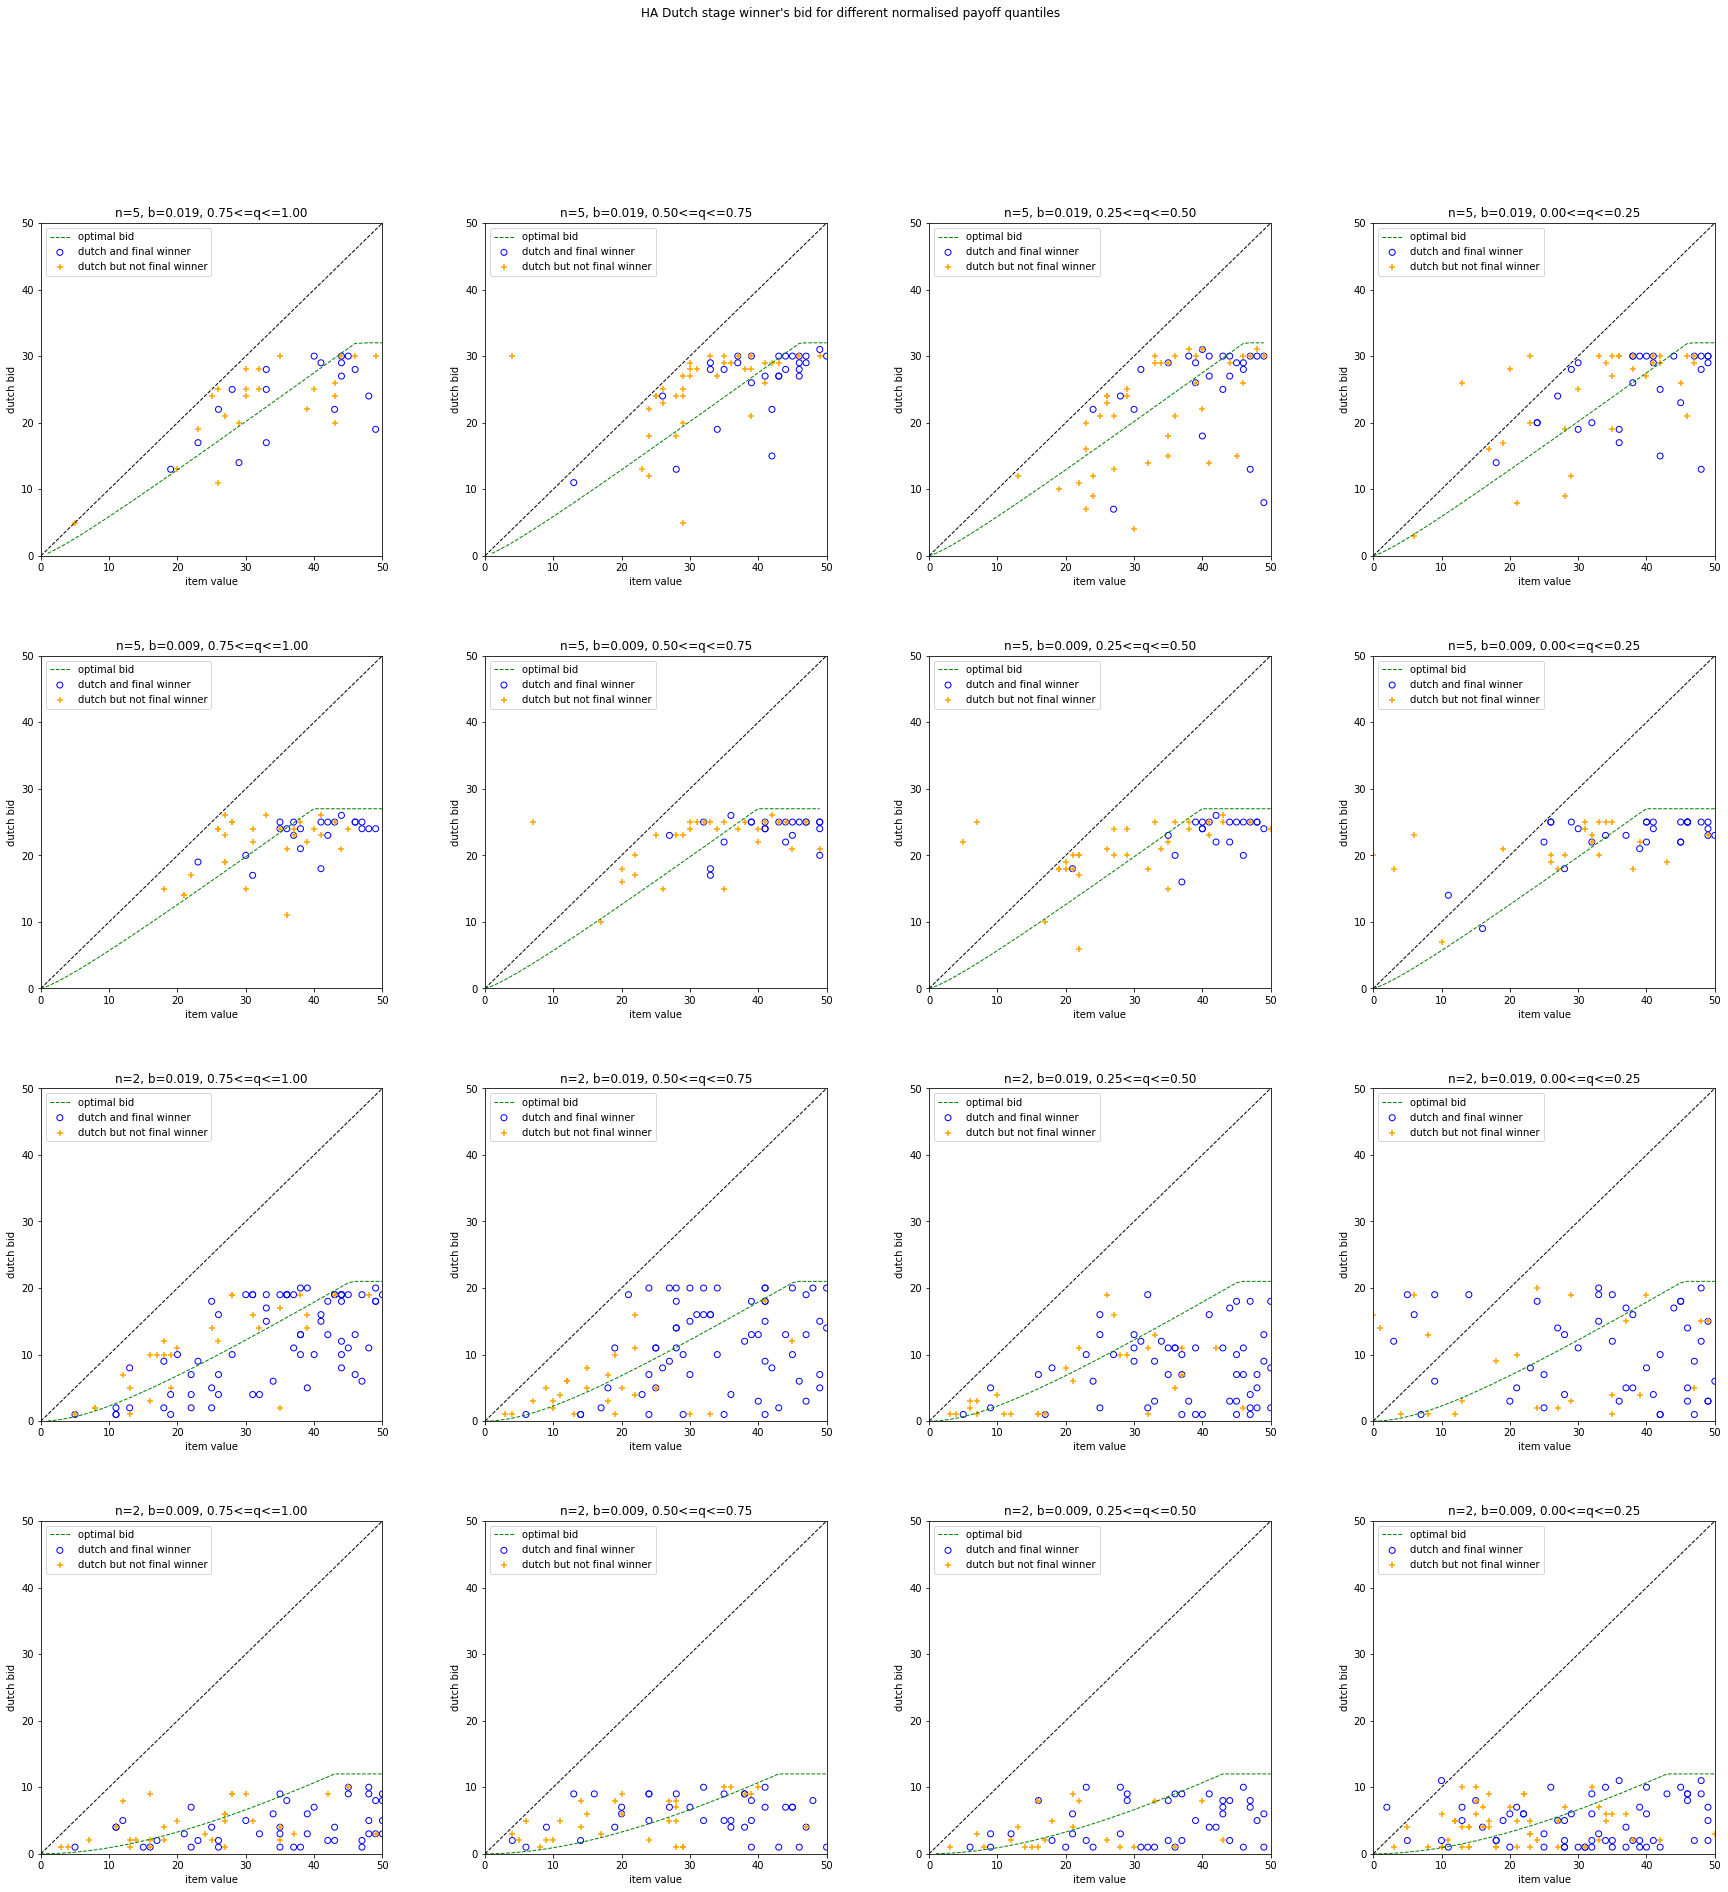

In [ ]:
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(4, 4, 1)
hDutchNormdiffPlot(5, 0.019, 0.75, 1)
plt.subplot(4, 4, 2)
hDutchNormdiffPlot(5, 0.019, 0.5, 0.75)
plt.subplot(4, 4, 3)
hDutchNormdiffPlot(5, 0.019, 0.25, 0.5)
plt.subplot(4, 4, 4)
hDutchNormdiffPlot(5, 0.019, 0, 0.25)
plt.subplot(4, 4, 5)
hDutchNormdiffPlot(5, 0.009, 0.75, 1)
plt.subplot(4, 4, 6)
hDutchNormdiffPlot(5, 0.009, 0.5, 0.75)
plt.subplot(4, 4, 7)
hDutchNormdiffPlot(5, 0.009, 0.25, 0.5)
plt.subplot(4, 4, 8)
hDutchNormdiffPlot(5, 0.009, 0, 0.25)
plt.subplot(4, 4, 9)
hDutchNormdiffPlot(2, 0.019, 0.75, 1)
plt.subplot(4, 4, 10)
hDutchNormdiffPlot(2, 0.019, 0.5, 0.75)
plt.subplot(4, 4, 11)
hDutchNormdiffPlot(2, 0.019, 0.25, 0.5)
plt.subplot(4, 4, 12)
hDutchNormdiffPlot(2, 0.019, 0, 0.25)
plt.subplot(4, 4, 13)
hDutchNormdiffPlot(2, 0.009, 0.75, 1)
plt.subplot(4, 4, 14)
hDutchNormdiffPlot(2, 0.009, 0.5, 0.75)
plt.subplot(4, 4, 15)
hDutchNormdiffPlot(2, 0.009, 0.25, 0.5)
plt.subplot(4, 4, 16)
hDutchNormdiffPlot(2, 0.009, 0, 0.25)
plt.suptitle("HA Dutch stage winner\'s bid for different normalised payoff quantiles")

In [ ]:
def hContestNormdiffPlot(n, b, qmin, qmax):
    mindiff = np.quantile(list(h_dict_paydiff_norm[(n, b)].values()), qmin)
    maxdiff = np.quantile(list(h_dict_paydiff_norm[(n, b)].values()), qmax)
    p_code_list = [k for (k, v) in h_dict_paydiff_norm[(n, b)].items() if (v >= mindiff and v <= maxdiff)]
    tmp = df_h[df_h["participant.code"].isin(p_code_list)]
    tmpx1 = tmp[(tmp["player.contest_status"] == 1) & (tmp["player.is_dutch_winner"] != 1) & (tmp["player.is_final_winner"] == 1)]["player.item_value"]
    tmpy1 = tmp[(tmp["player.contest_status"] == 1) & (tmp["player.is_dutch_winner"] != 1) & (tmp["player.is_final_winner"] == 1)]["group.dutch_final_price"]
    tmpx2 = tmp[(tmp["player.contest_status"] == 1) & (tmp["player.is_dutch_winner"] != 1) & (tmp["player.is_final_winner"] != 1)]["player.item_value"]
    tmpy2 = tmp[(tmp["player.contest_status"] == 1) & (tmp["player.is_dutch_winner"] != 1) & (tmp["player.is_final_winner"] != 1)]["group.dutch_final_price"]
    tmpx3 = tmp[(tmp["player.contest_status"] != 1) & (tmp["player.item_value"] >= tmp["group.dutch_final_price"])]["player.item_value"]
    tmpy3 = tmp[(tmp["player.contest_status"] != 1) & (tmp["player.item_value"] >= tmp["group.dutch_final_price"])]["group.dutch_final_price"]
    plt.axline((0, 0), (50, 50), color="black", linewidth=1, linestyle="--")
    plt.scatter(tmpx1, tmpy1, marker="o", color="none", edgecolor="blue", label="bid and final winner")
    plt.scatter(tmpx2, tmpy2, marker="+", color="darkorange", label="bid but not final winner")
    plt.scatter(tmpx3, tmpy3, marker="x", color="green", label="leave with positive payoff")
    plt.xlabel("item value")
    plt.ylabel("contest price")
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.legend()
    plt.title("n=%d, b=%.3f, %.2f<=q<=%.2f" % (n, b, qmin, qmax))

Text(0.5, 0.98, "HA Contest stage contestant's bid for different normalised payoff quantiles")

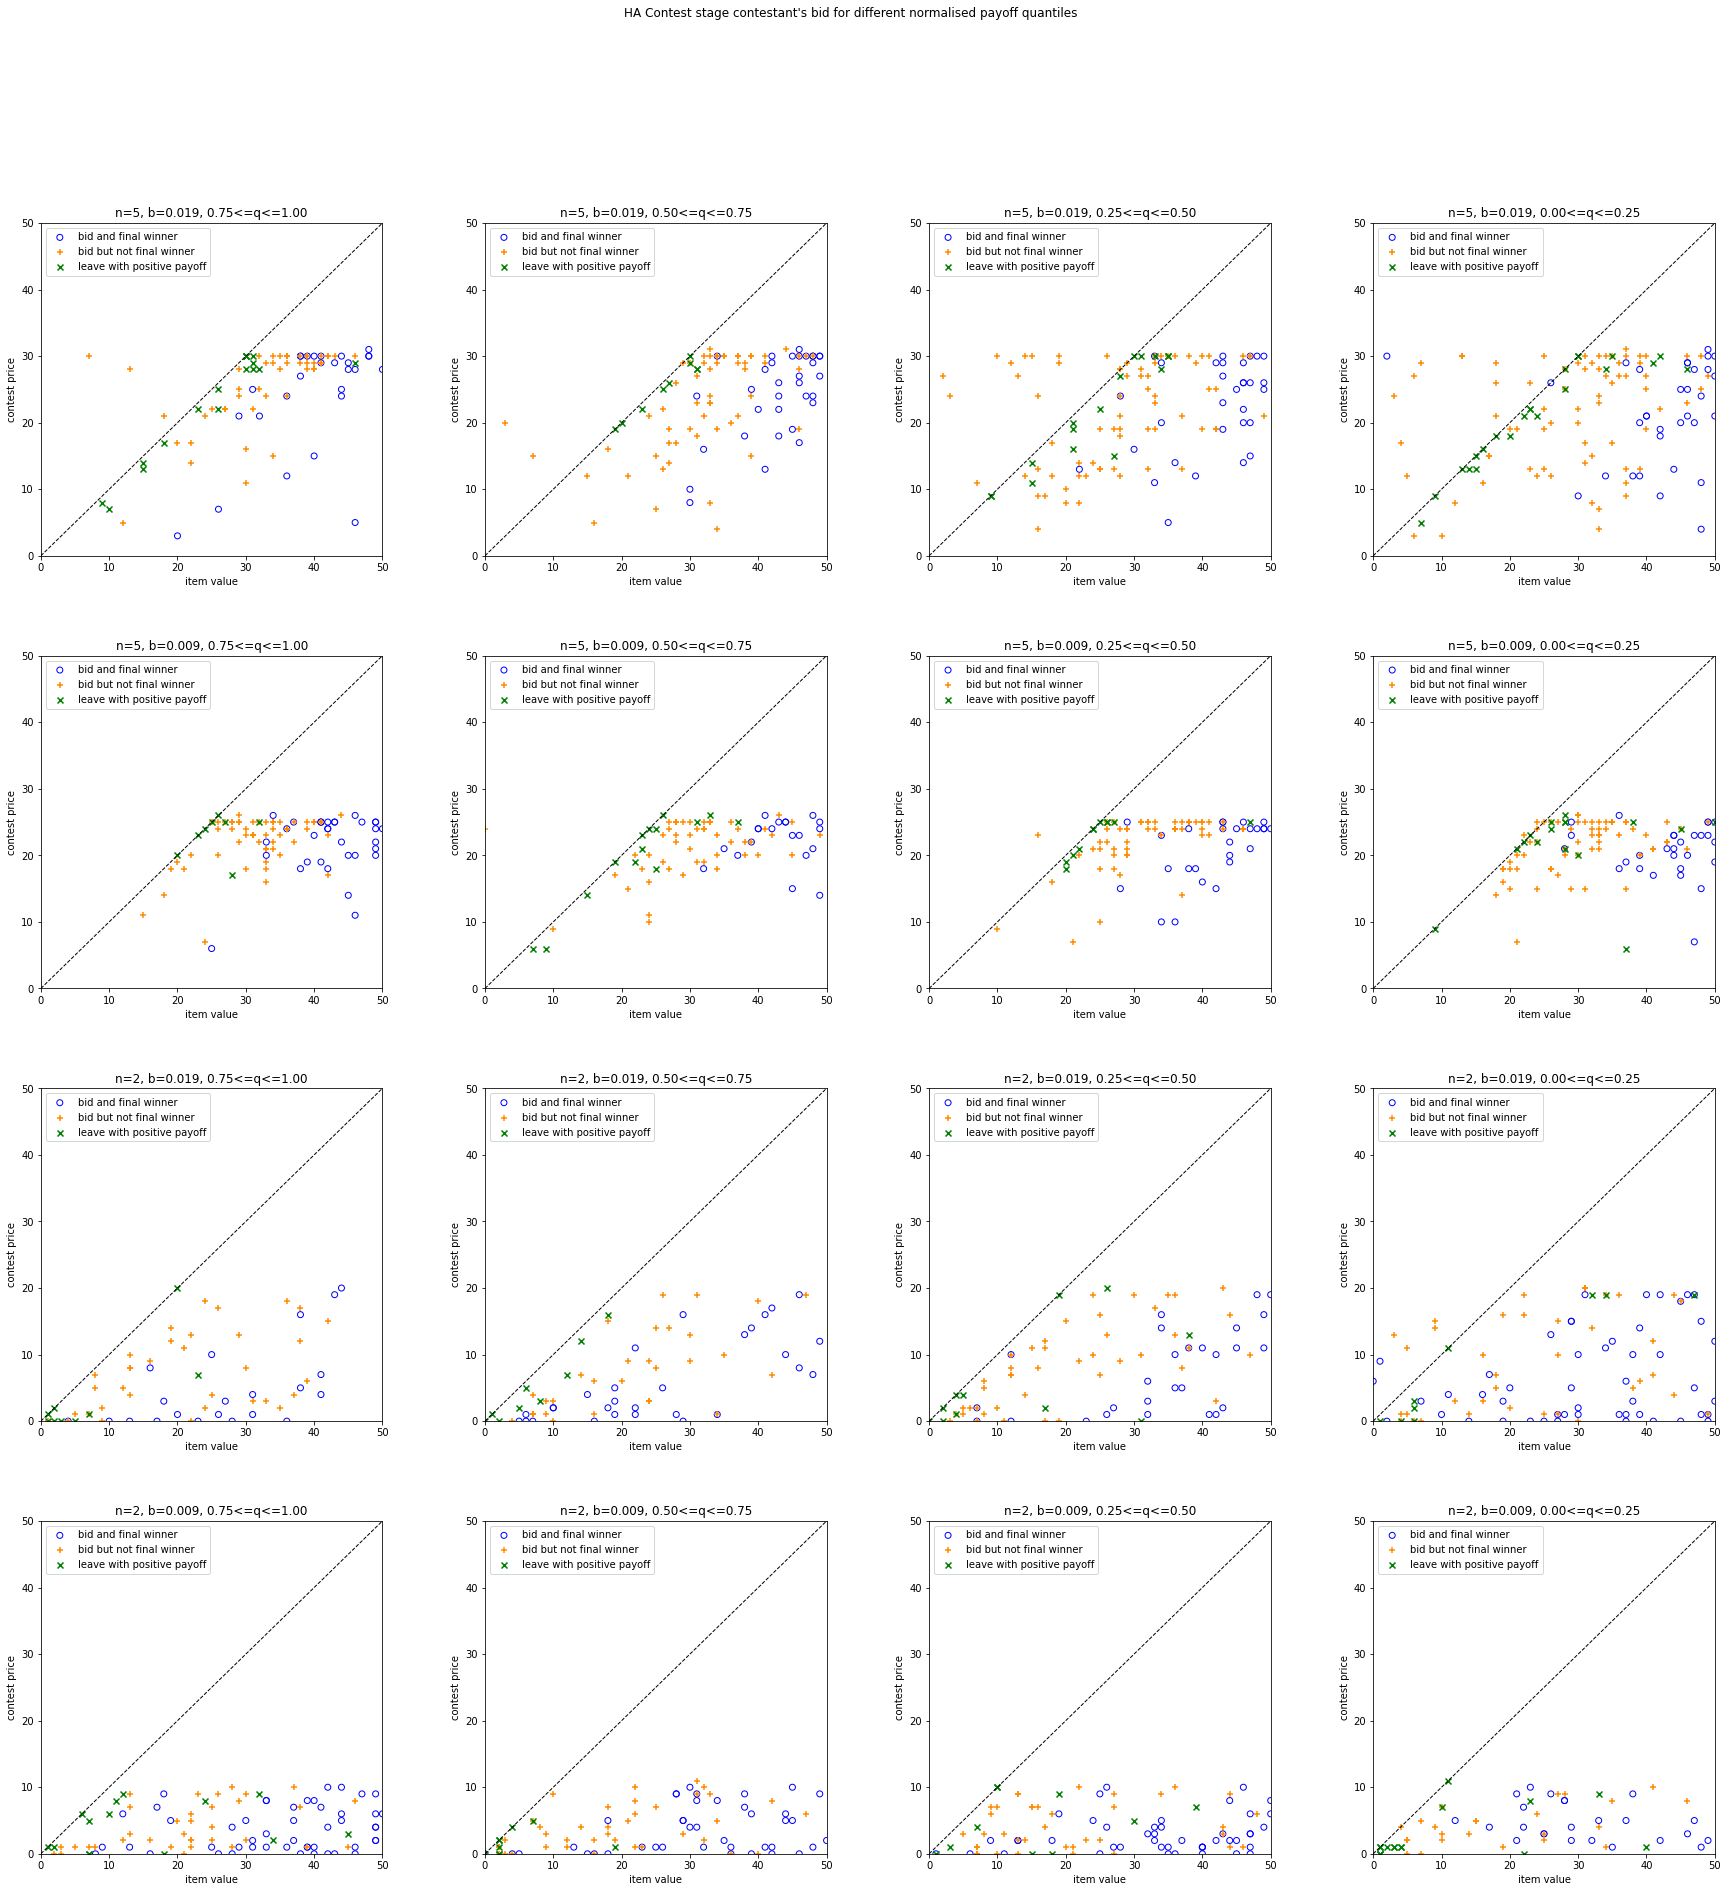

In [ ]:
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(4, 4, 1)
hContestNormdiffPlot(5, 0.019, 0.75, 1)
plt.subplot(4, 4, 2)
hContestNormdiffPlot(5, 0.019, 0.5, 0.75)
plt.subplot(4, 4, 3)
hContestNormdiffPlot(5, 0.019, 0.25, 0.5)
plt.subplot(4, 4, 4)
hContestNormdiffPlot(5, 0.019, 0, 0.25)
plt.subplot(4, 4, 5)
hContestNormdiffPlot(5, 0.009, 0.75, 1)
plt.subplot(4, 4, 6)
hContestNormdiffPlot(5, 0.009, 0.5, 0.75)
plt.subplot(4, 4, 7)
hContestNormdiffPlot(5, 0.009, 0.25, 0.5)
plt.subplot(4, 4, 8)
hContestNormdiffPlot(5, 0.009, 0, 0.25)
plt.subplot(4, 4, 9)
hContestNormdiffPlot(2, 0.019, 0.75, 1)
plt.subplot(4, 4, 10)
hContestNormdiffPlot(2, 0.019, 0.5, 0.75)
plt.subplot(4, 4, 11)
hContestNormdiffPlot(2, 0.019, 0.25, 0.5)
plt.subplot(4, 4, 12)
hContestNormdiffPlot(2, 0.019, 0, 0.25)
plt.subplot(4, 4, 13)
hContestNormdiffPlot(2, 0.009, 0.75, 1)
plt.subplot(4, 4, 14)
hContestNormdiffPlot(2, 0.009, 0.5, 0.75)
plt.subplot(4, 4, 15)
hContestNormdiffPlot(2, 0.009, 0.25, 0.5)
plt.subplot(4, 4, 16)
hContestNormdiffPlot(2, 0.009, 0, 0.25)
plt.suptitle("HA Contest stage contestant\'s bid for different normalised payoff quantiles")

In [ ]:
def hEnglishNormdiffPlot(n, b, qmin, qmax):
    mindiff = np.quantile(list(h_dict_paydiff_norm[(n, b)].values()), qmin)
    maxdiff = np.quantile(list(h_dict_paydiff_norm[(n, b)].values()), qmax)
    p_code_list = [k for (k, v) in h_dict_paydiff_norm[(n, b)].items() if (v >= mindiff and v <= maxdiff)]
    tmp = df_h[df_h["participant.code"].isin(p_code_list)]
    tmpx1 = tmp[(tmp["player.contest_status"] == 1) & (tmp["player.is_english_winner"] == 1)]["player.item_value"]
    tmpy1 = tmp[(tmp["player.contest_status"] == 1) & (tmp["player.is_english_winner"] == 1)]["player.dropout_price"]
    tmpx2 = tmp[(tmp["player.contest_status"] == 1) & (tmp["player.is_english_winner"] == 0)]["player.item_value"]
    tmpy2 = tmp[(tmp["player.contest_status"] == 1) & (tmp["player.is_english_winner"] == 0)]["group.english_final_price"]
    plt.axline((0, 0), (50, 50), color="black", linewidth=1, linestyle="--")
    plt.scatter(tmpx1, tmpy1, marker="o", color="none", edgecolor="blue", label="english winner")
    plt.scatter(tmpx2, tmpy2, marker="+", color="orange", label="not english winner")
    plt.xlabel("item value")
    plt.ylabel("english leave price")
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.legend()
    plt.title("n=%d, b=%.3f, %.2f<=q<=%.2f" % (n, b, qmin, qmax))

Text(0.5, 0.98, "HA English stage non-winner's leave for different normalised payoff quantiles")

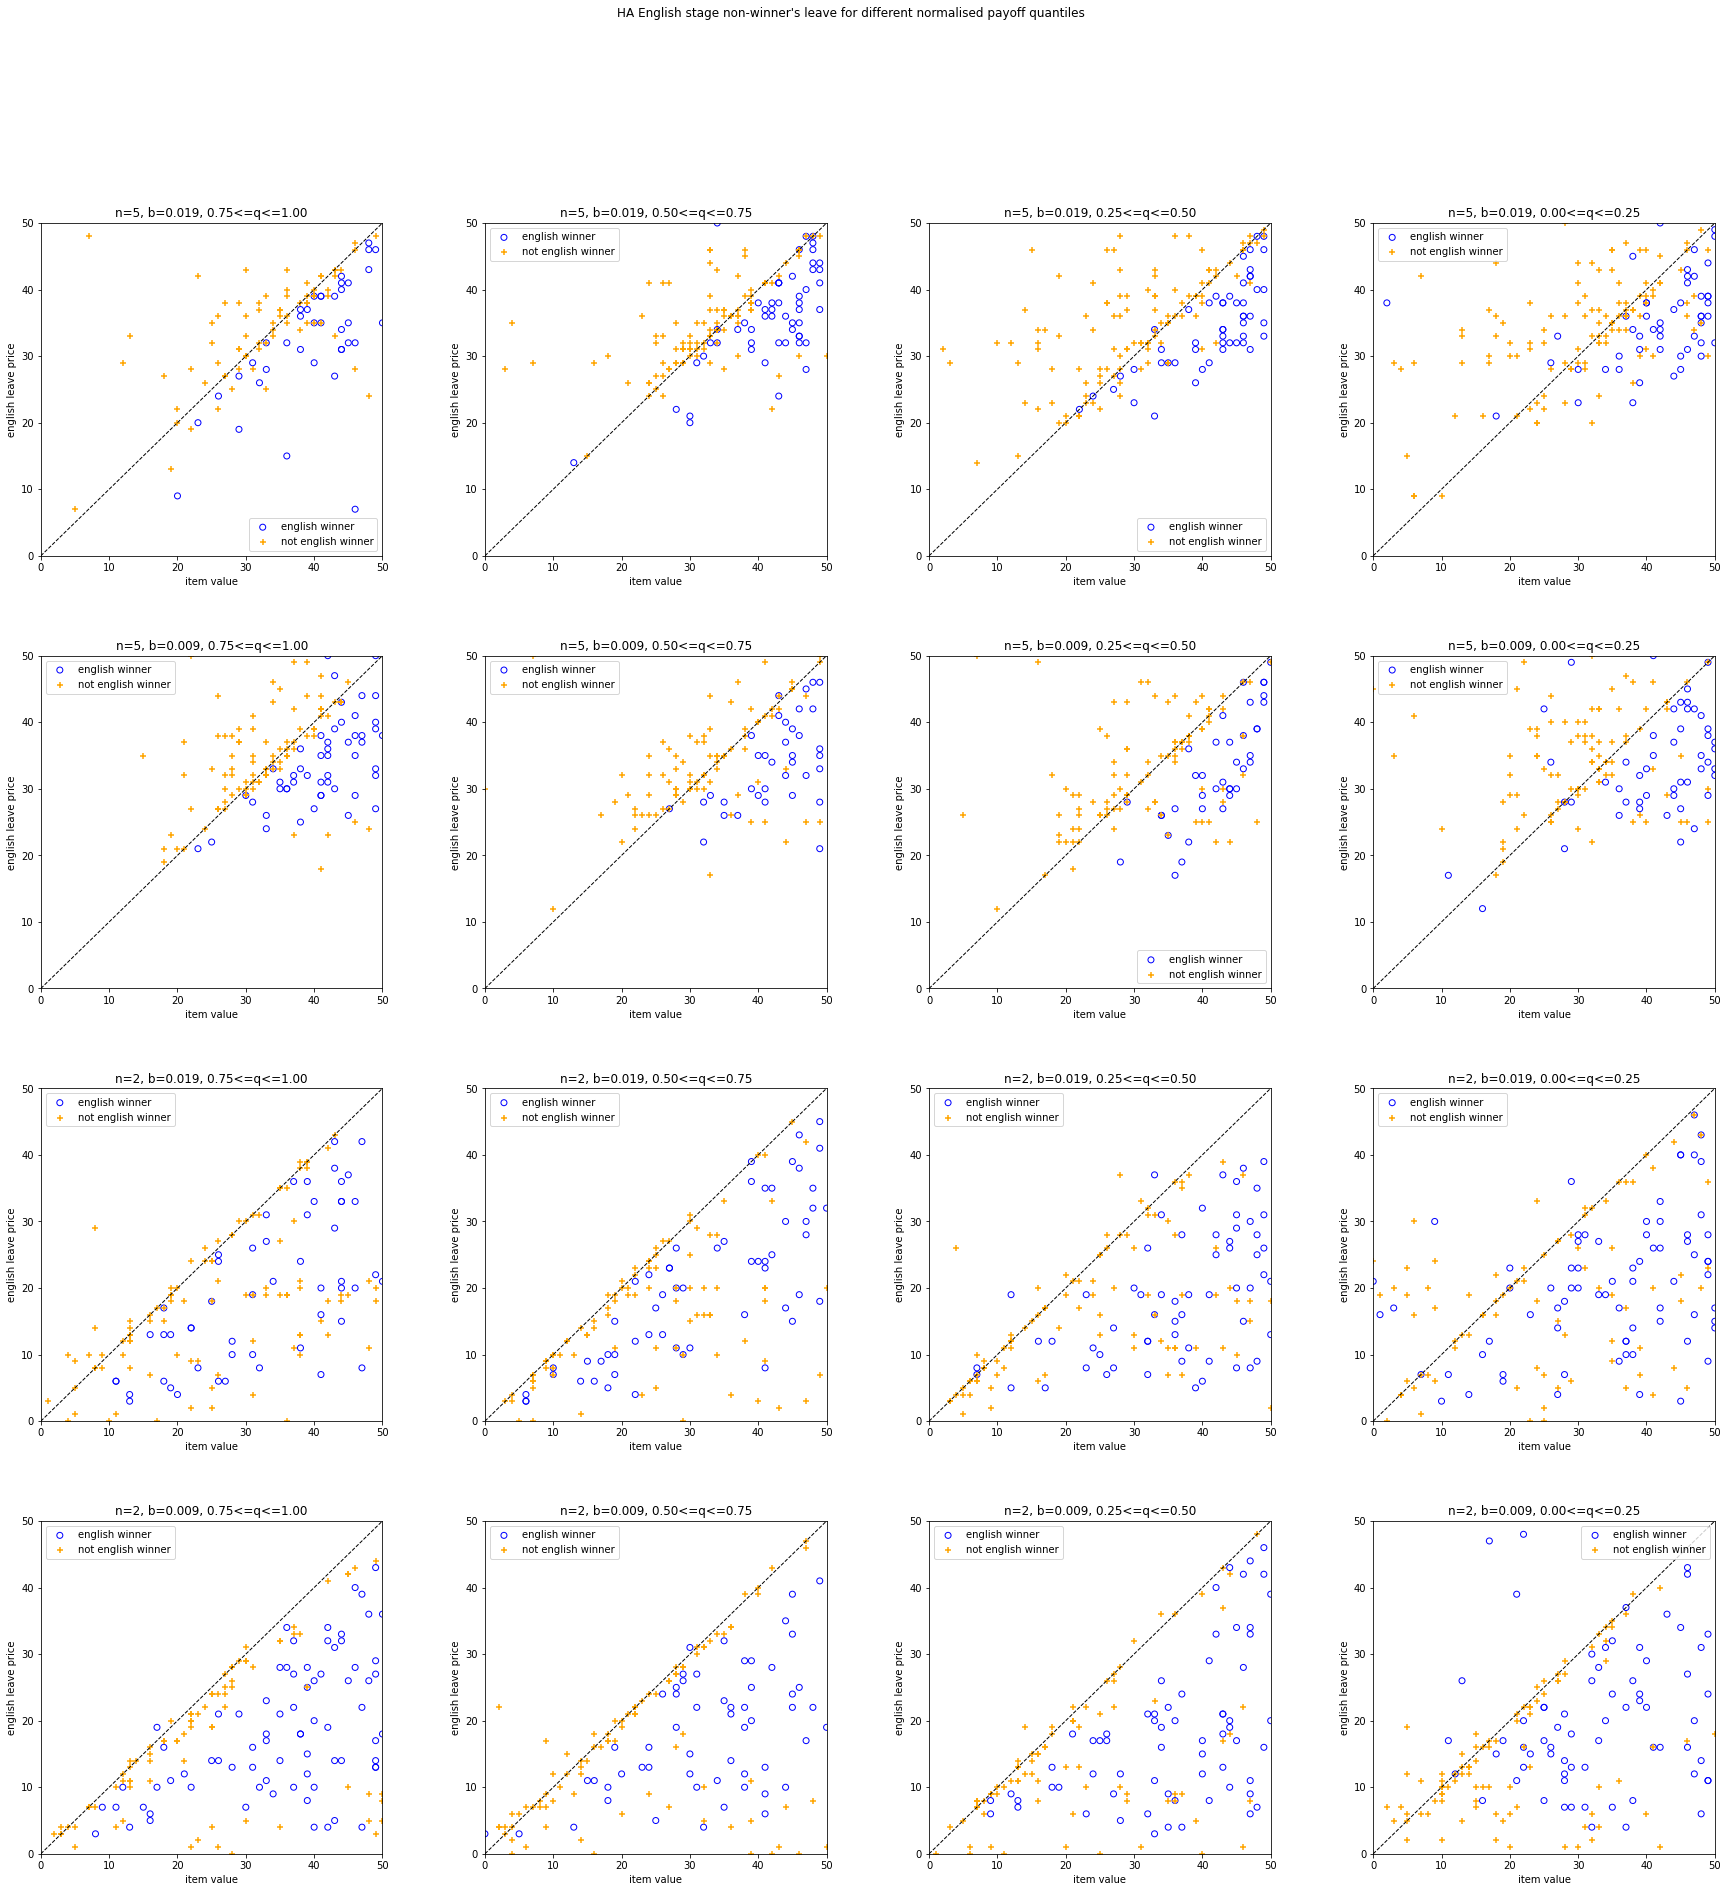

In [ ]:
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(4, 4, 1)
hEnglishNormdiffPlot(5, 0.019, 0.75, 1)
plt.subplot(4, 4, 2)
hEnglishNormdiffPlot(5, 0.019, 0.5, 0.75)
plt.subplot(4, 4, 3)
hEnglishNormdiffPlot(5, 0.019, 0.25, 0.5)
plt.subplot(4, 4, 4)
hEnglishNormdiffPlot(5, 0.019, 0, 0.25)
plt.subplot(4, 4, 5)
hEnglishNormdiffPlot(5, 0.009, 0.75, 1)
plt.subplot(4, 4, 6)
hEnglishNormdiffPlot(5, 0.009, 0.5, 0.75)
plt.subplot(4, 4, 7)
hEnglishNormdiffPlot(5, 0.009, 0.25, 0.5)
plt.subplot(4, 4, 8)
hEnglishNormdiffPlot(5, 0.009, 0, 0.25)
plt.subplot(4, 4, 9)
hEnglishNormdiffPlot(2, 0.019, 0.75, 1)
plt.subplot(4, 4, 10)
hEnglishNormdiffPlot(2, 0.019, 0.5, 0.75)
plt.subplot(4, 4, 11)
hEnglishNormdiffPlot(2, 0.019, 0.25, 0.5)
plt.subplot(4, 4, 12)
hEnglishNormdiffPlot(2, 0.019, 0, 0.25)
plt.subplot(4, 4, 13)
hEnglishNormdiffPlot(2, 0.009, 0.75, 1)
plt.subplot(4, 4, 14)
hEnglishNormdiffPlot(2, 0.009, 0.5, 0.75)
plt.subplot(4, 4, 15)
hEnglishNormdiffPlot(2, 0.009, 0.25, 0.5)
plt.subplot(4, 4, 16)
hEnglishNormdiffPlot(2, 0.009, 0, 0.25)
plt.suptitle("HA English stage non-winner\'s leave for different normalised payoff quantiles")

#### Percentage Payoff

In [ ]:
def dDutchPctdiffPlot(n, b, qmin, qmax):
    mindiff = np.quantile(list(d_dict_paydiff_pct[(n, b)].values()), qmin)
    maxdiff = np.quantile(list(d_dict_paydiff_pct[(n, b)].values()), qmax)
    p_code_list = [k for (k, v) in d_dict_paydiff_pct[(n, b)].items() if (v >= mindiff and v <= maxdiff)]
    tmp = df_d[df_d["participant.code"].isin(p_code_list)]
    tmpx = tmp["player.item_value"].sort_values()
    tmpy = tmp["predict.player.bid"].sort_values()
    tmpx1 = tmp[tmp["player.is_dutch_winner"] == 1]["player.item_value"].tolist()
    tmpy1 = tmp[tmp["player.is_dutch_winner"] == 1]["group.dutch_final_price"].tolist()
    model = LinearRegression(fit_intercept=False)
    model.fit(np.reshape(tmpx1, (-1, 1)), tmpy1)
    # tmpx2 = tmp[tmp["player.is_dutch_winner"] == 0]["player.item_value"]
    # tmpy2 = tmp[tmp["player.is_dutch_winner"] == 0]["group.dutch_final_price"]
    plt.axline((0, 0), (50, 50), color="black", linewidth=1, linestyle="--")
    plt.axline((0, 0), (50, 50 * (n - 1) / n), color="purple", linewidth=1, linestyle="--", label="zero-cost prediction")
    plt.plot(tmpx, tmpy, color="green", linewidth=1, label="optimal bid")
    plt.scatter(tmpx1, tmpy1, marker="o", color="none", edgecolor="blue", label="is dutch winner")
    plt.axline((0, 0), (50, model.predict([[50]])[0]), color="red", label="reg slope=%.4f"%(model.coef_[0]))
    # plt.scatter(tmpx2, tmpy2, marker="+", color="darkorange", label="not dutch winner")
    plt.xlabel("item value")
    plt.ylabel("dutch bid")
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.legend()
    plt.title("n=%d, b=%.3f, %.2f<=q<=%.2f" % (n, b, qmin, qmax))

Text(0.5, 0.98, "DA winner's bid for different percentage payoff quantiles")

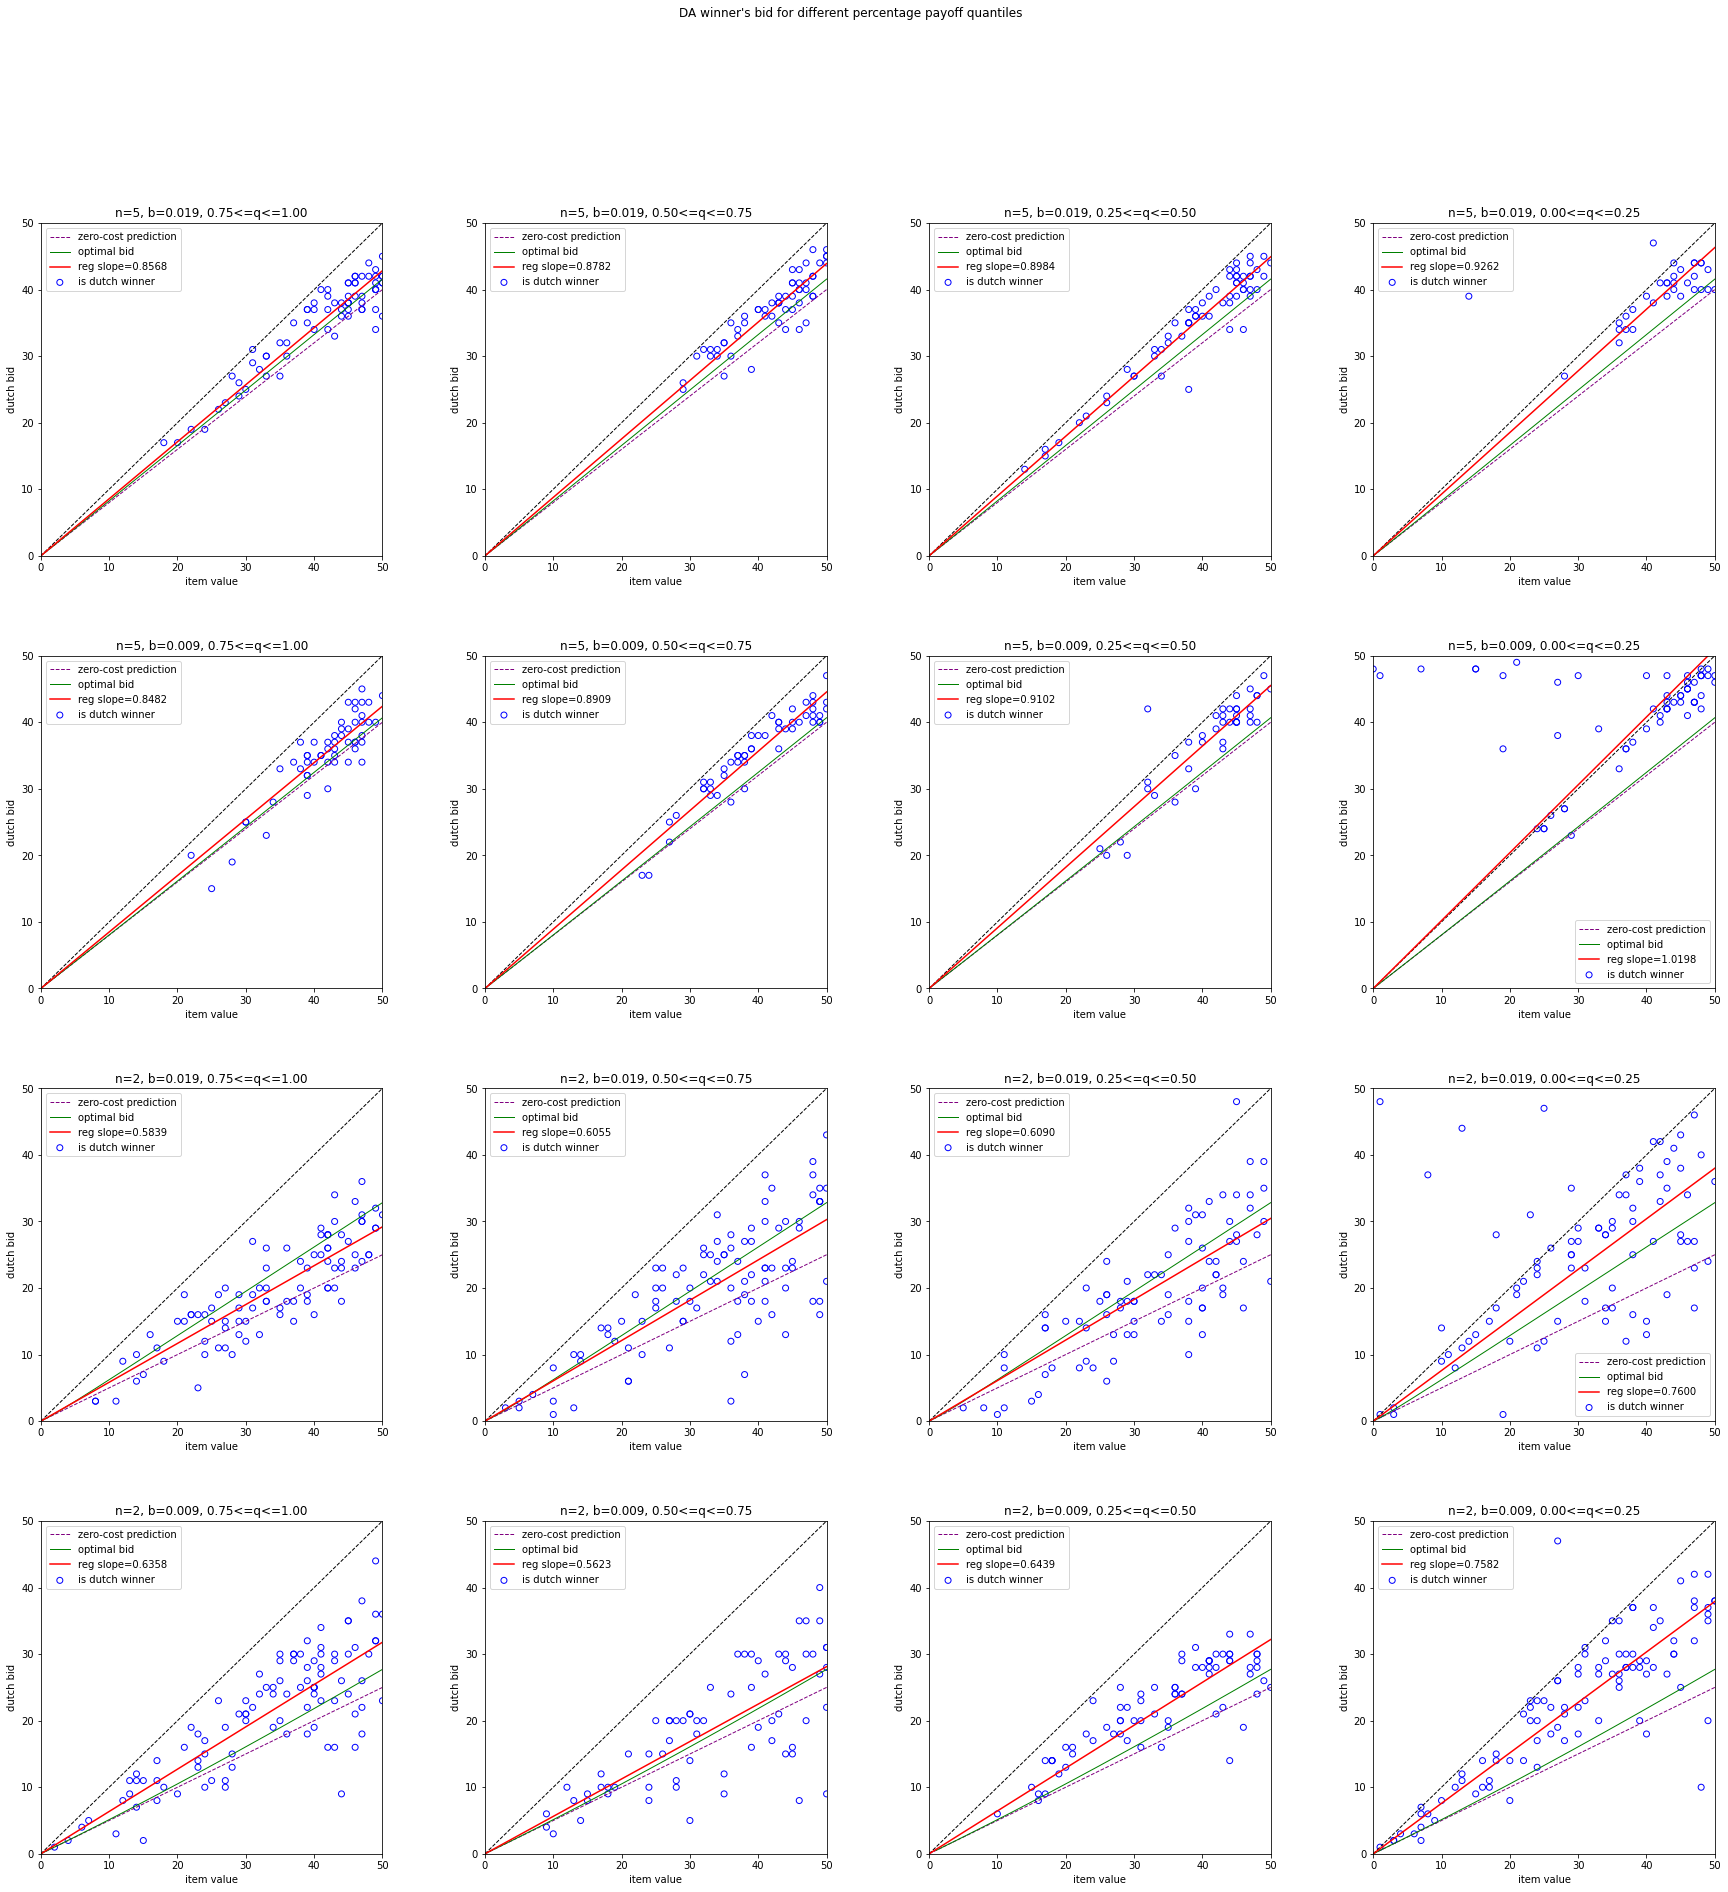

In [ ]:
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(4, 4, 1)
dDutchPctdiffPlot(5, 0.019, 0.75, 1)
plt.subplot(4, 4, 2)
dDutchPctdiffPlot(5, 0.019, 0.5, 0.75)
plt.subplot(4, 4, 3)
dDutchPctdiffPlot(5, 0.019, 0.25, 0.5)
plt.subplot(4, 4, 4)
dDutchPctdiffPlot(5, 0.019, 0, 0.25)
plt.subplot(4, 4, 5)
dDutchPctdiffPlot(5, 0.009, 0.75, 1)
plt.subplot(4, 4, 6)
dDutchPctdiffPlot(5, 0.009, 0.5, 0.75)
plt.subplot(4, 4, 7)
dDutchPctdiffPlot(5, 0.009, 0.25, 0.5)
plt.subplot(4, 4, 8)
dDutchPctdiffPlot(5, 0.009, 0, 0.25)
plt.subplot(4, 4, 9)
dDutchPctdiffPlot(2, 0.019, 0.75, 1)
plt.subplot(4, 4, 10)
dDutchPctdiffPlot(2, 0.019, 0.5, 0.75)
plt.subplot(4, 4, 11)
dDutchPctdiffPlot(2, 0.019, 0.25, 0.5)
plt.subplot(4, 4, 12)
dDutchPctdiffPlot(2, 0.019, 0, 0.25)
plt.subplot(4, 4, 13)
dDutchPctdiffPlot(2, 0.009, 0.75, 1)
plt.subplot(4, 4, 14)
dDutchPctdiffPlot(2, 0.009, 0.5, 0.75)
plt.subplot(4, 4, 15)
dDutchPctdiffPlot(2, 0.009, 0.25, 0.5)
plt.subplot(4, 4, 16)
dDutchPctdiffPlot(2, 0.009, 0, 0.25)
plt.suptitle("DA winner\'s bid for different percentage payoff quantiles")

In [ ]:
def hDutchPctdiffPlot(n, b, qmin, qmax):
    mindiff = np.quantile(list(h_dict_paydiff_pct[(n, b)].values()), qmin)
    maxdiff = np.quantile(list(h_dict_paydiff_pct[(n, b)].values()), qmax)
    p_code_list = [k for (k, v) in h_dict_paydiff_pct[(n, b)].items() if (v >= mindiff and v <= maxdiff)]
    tmp = df_h[df_h["participant.code"].isin(p_code_list)]
    tmpx = tmp["player.item_value"].sort_values()
    tmpy = tmp["predict.player.optimal_dutch_bid"].sort_values()
    tmpx1 = tmp[tmp["player.is_dutch_winner"] == 1]["player.item_value"]
    tmpy1 = tmp[tmp["player.is_dutch_winner"] == 1]["group.dutch_final_price"]
    # tmpx2 = tmp[tmp["player.is_dutch_winner"] == 0]["player.item_value"]
    # tmpy2 = tmp[tmp["player.is_dutch_winner"] == 0]["group.dutch_final_price"]
    plt.axline((0, 0), (50, 50), color="black", linewidth=1, linestyle="--")
    plt.plot(tmpx, tmpy, color="green", linewidth=1, linestyle="--", label="optimal bid")
    plt.scatter(tmpx1, tmpy1, marker="o", color="none", edgecolor="blue", label="is dutch winner")
    # plt.scatter(tmpx2, tmpy2, marker="+", color="darkorange", label="not dutch winner")
    plt.xlabel("item value")
    plt.ylabel("dutch bid")
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.legend()
    plt.title("n=%d, b=%.3f, %.2f<=q<=%.2f" % (n, b, qmin, qmax))

Text(0.5, 0.98, "HA Dutch stage winner's bid for different percentage payoff quantiles")

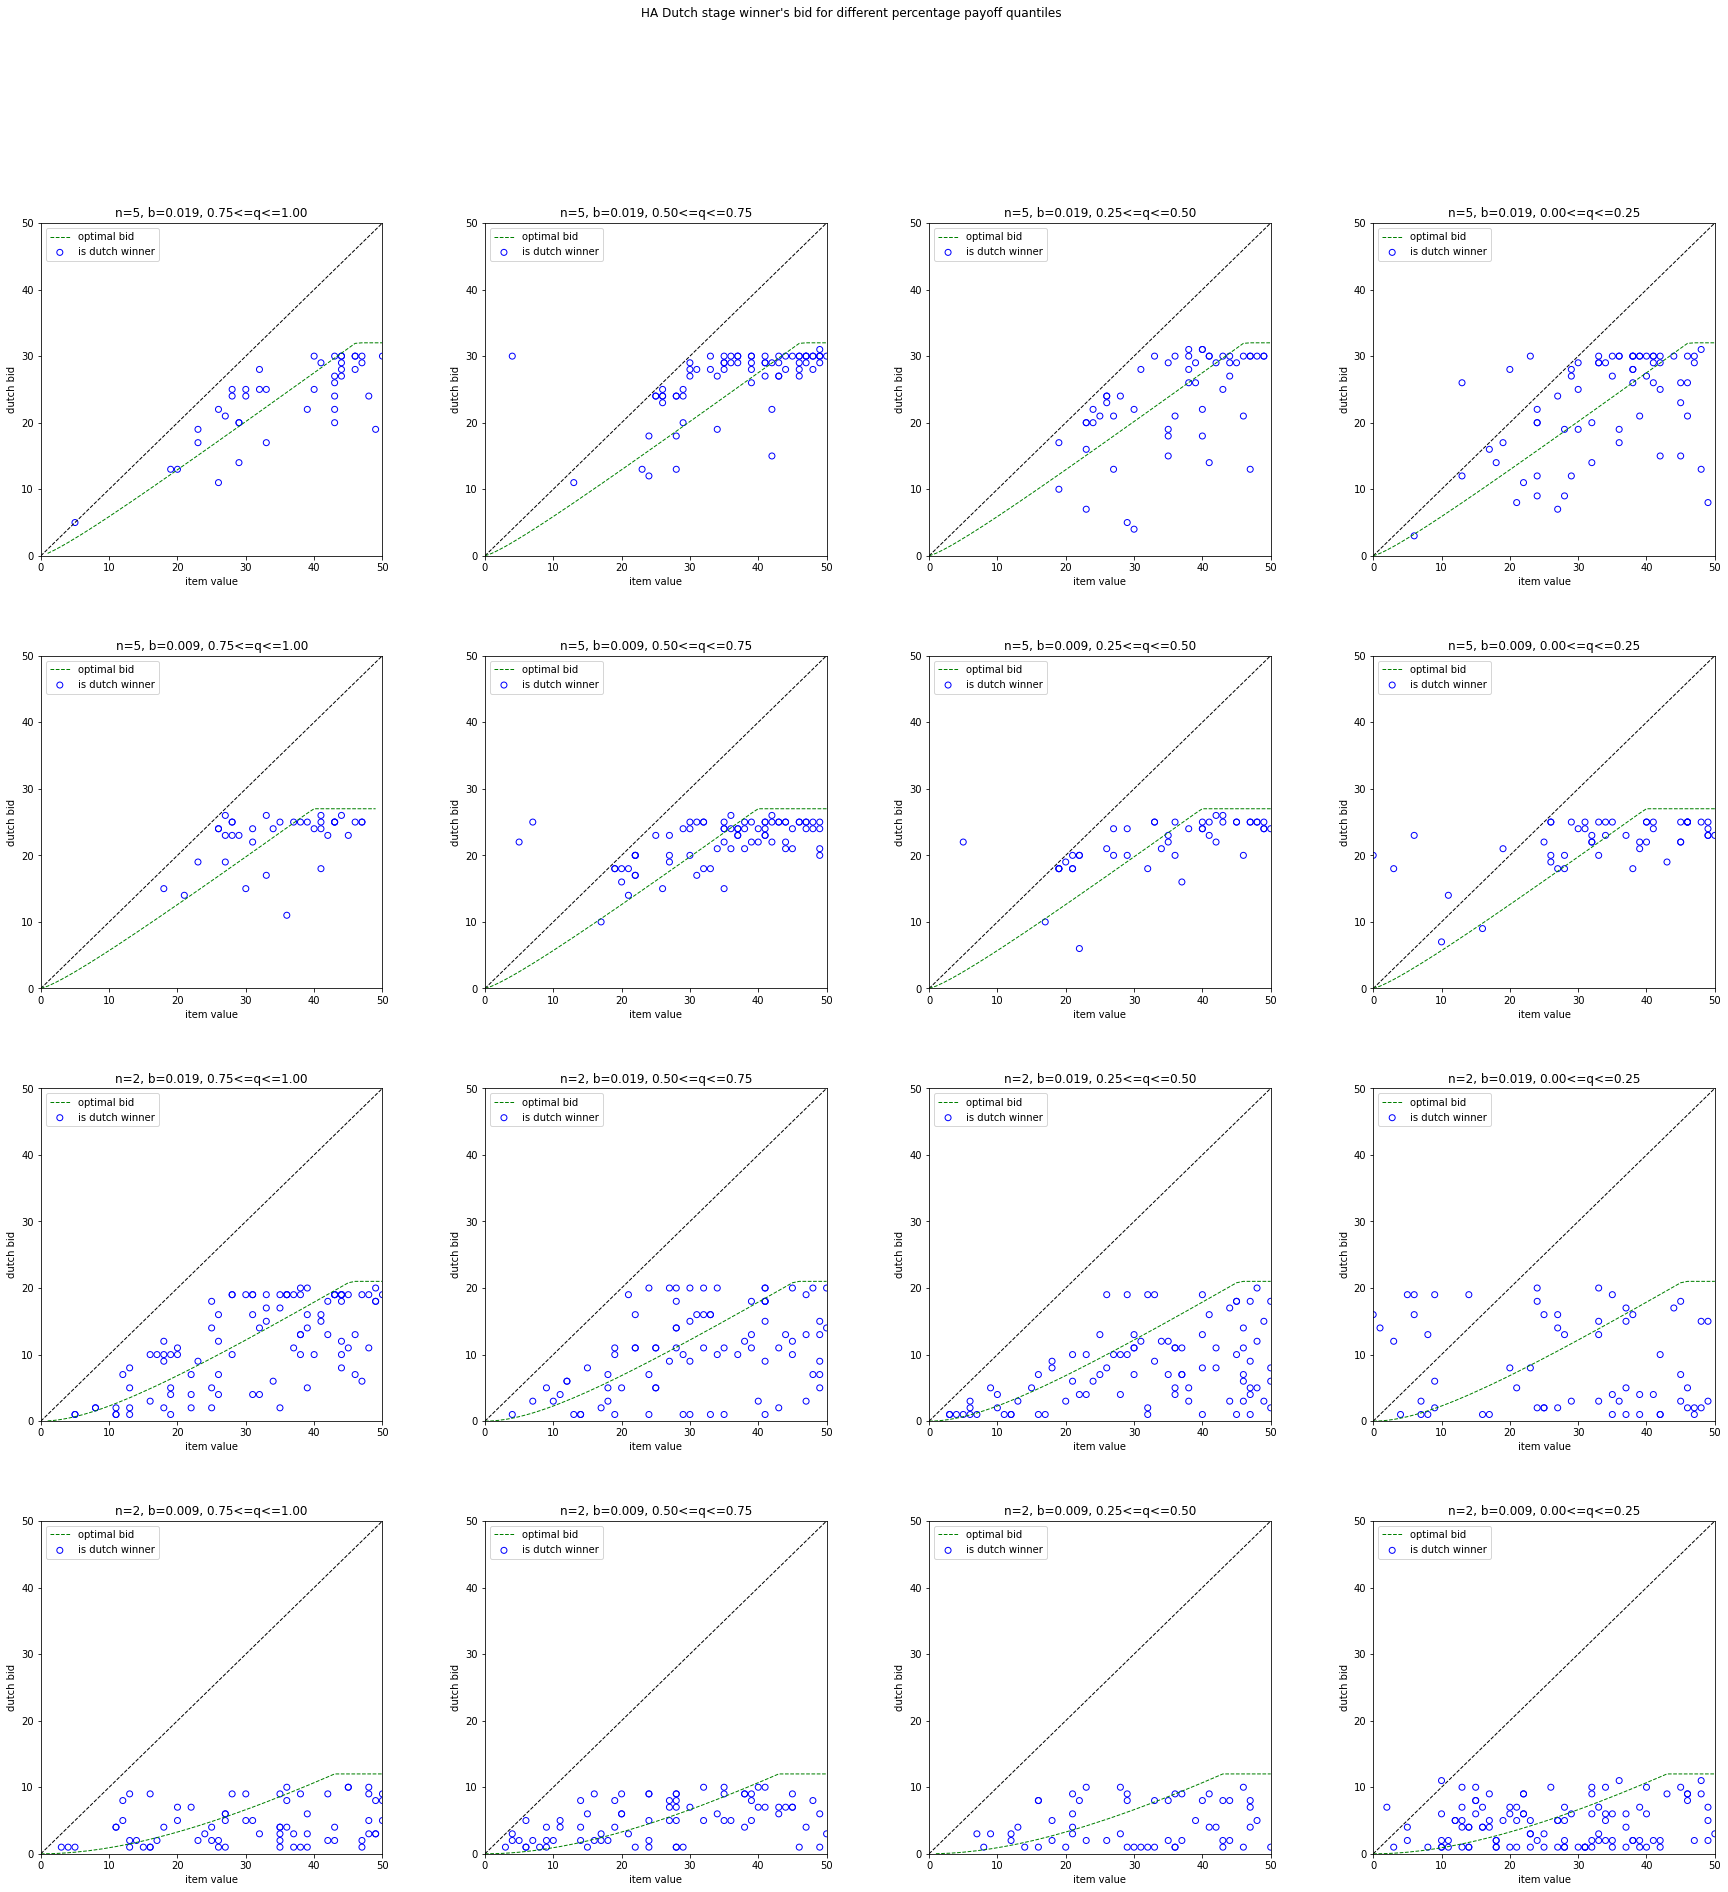

In [ ]:
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(4, 4, 1)
hDutchPctdiffPlot(5, 0.019, 0.75, 1)
plt.subplot(4, 4, 2)
hDutchPctdiffPlot(5, 0.019, 0.5, 0.75)
plt.subplot(4, 4, 3)
hDutchPctdiffPlot(5, 0.019, 0.25, 0.5)
plt.subplot(4, 4, 4)
hDutchPctdiffPlot(5, 0.019, 0, 0.25)
plt.subplot(4, 4, 5)
hDutchPctdiffPlot(5, 0.009, 0.75, 1)
plt.subplot(4, 4, 6)
hDutchPctdiffPlot(5, 0.009, 0.5, 0.75)
plt.subplot(4, 4, 7)
hDutchPctdiffPlot(5, 0.009, 0.25, 0.5)
plt.subplot(4, 4, 8)
hDutchPctdiffPlot(5, 0.009, 0, 0.25)
plt.subplot(4, 4, 9)
hDutchPctdiffPlot(2, 0.019, 0.75, 1)
plt.subplot(4, 4, 10)
hDutchPctdiffPlot(2, 0.019, 0.5, 0.75)
plt.subplot(4, 4, 11)
hDutchPctdiffPlot(2, 0.019, 0.25, 0.5)
plt.subplot(4, 4, 12)
hDutchPctdiffPlot(2, 0.019, 0, 0.25)
plt.subplot(4, 4, 13)
hDutchPctdiffPlot(2, 0.009, 0.75, 1)
plt.subplot(4, 4, 14)
hDutchPctdiffPlot(2, 0.009, 0.5, 0.75)
plt.subplot(4, 4, 15)
hDutchPctdiffPlot(2, 0.009, 0.25, 0.5)
plt.subplot(4, 4, 16)
hDutchPctdiffPlot(2, 0.009, 0, 0.25)
plt.suptitle("HA Dutch stage winner\'s bid for different percentage payoff quantiles")

In [ ]:
def hContestPctdiffPlot(n, b, qmin, qmax):
    mindiff = np.quantile(list(h_dict_paydiff_pct[(n, b)].values()), qmin)
    maxdiff = np.quantile(list(h_dict_paydiff_pct[(n, b)].values()), qmax)
    p_code_list = [k for (k, v) in h_dict_paydiff_pct[(n, b)].items() if (v >= mindiff and v <= maxdiff)]
    tmp = df_h[df_h["participant.code"].isin(p_code_list)]
    tmpx1 = tmp[tmp["player.contest_status"] == 1]["player.item_value"]
    tmpy1 = tmp[tmp["player.contest_status"] == 1]["group.dutch_final_price"]
    # tmpx2 = tmp[tmp["player.contest_status"] != 1]["player.item_value"]
    # tmpy2 = tmp[tmp["player.contest_status"] != 1]["group.dutch_final_price"]
    plt.axline((0, 0), (50, 50), color="black", linewidth=1, linestyle="--")
    plt.scatter(tmpx1, tmpy1, marker="o", color="none", edgecolor="blue", label="bid")
    # plt.scatter(tmpx2, tmpy2, marker="+", color="darkorange", label="leave")
    plt.xlabel("item value")
    plt.ylabel("contest price")
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.legend()
    plt.title("n=%d, b=%.3f, %.2f<=q<=%.2f" % (n, b, qmin, qmax))

Text(0.5, 0.98, 'HA Contest stage bidding decision for different percentage payoff quantiles')

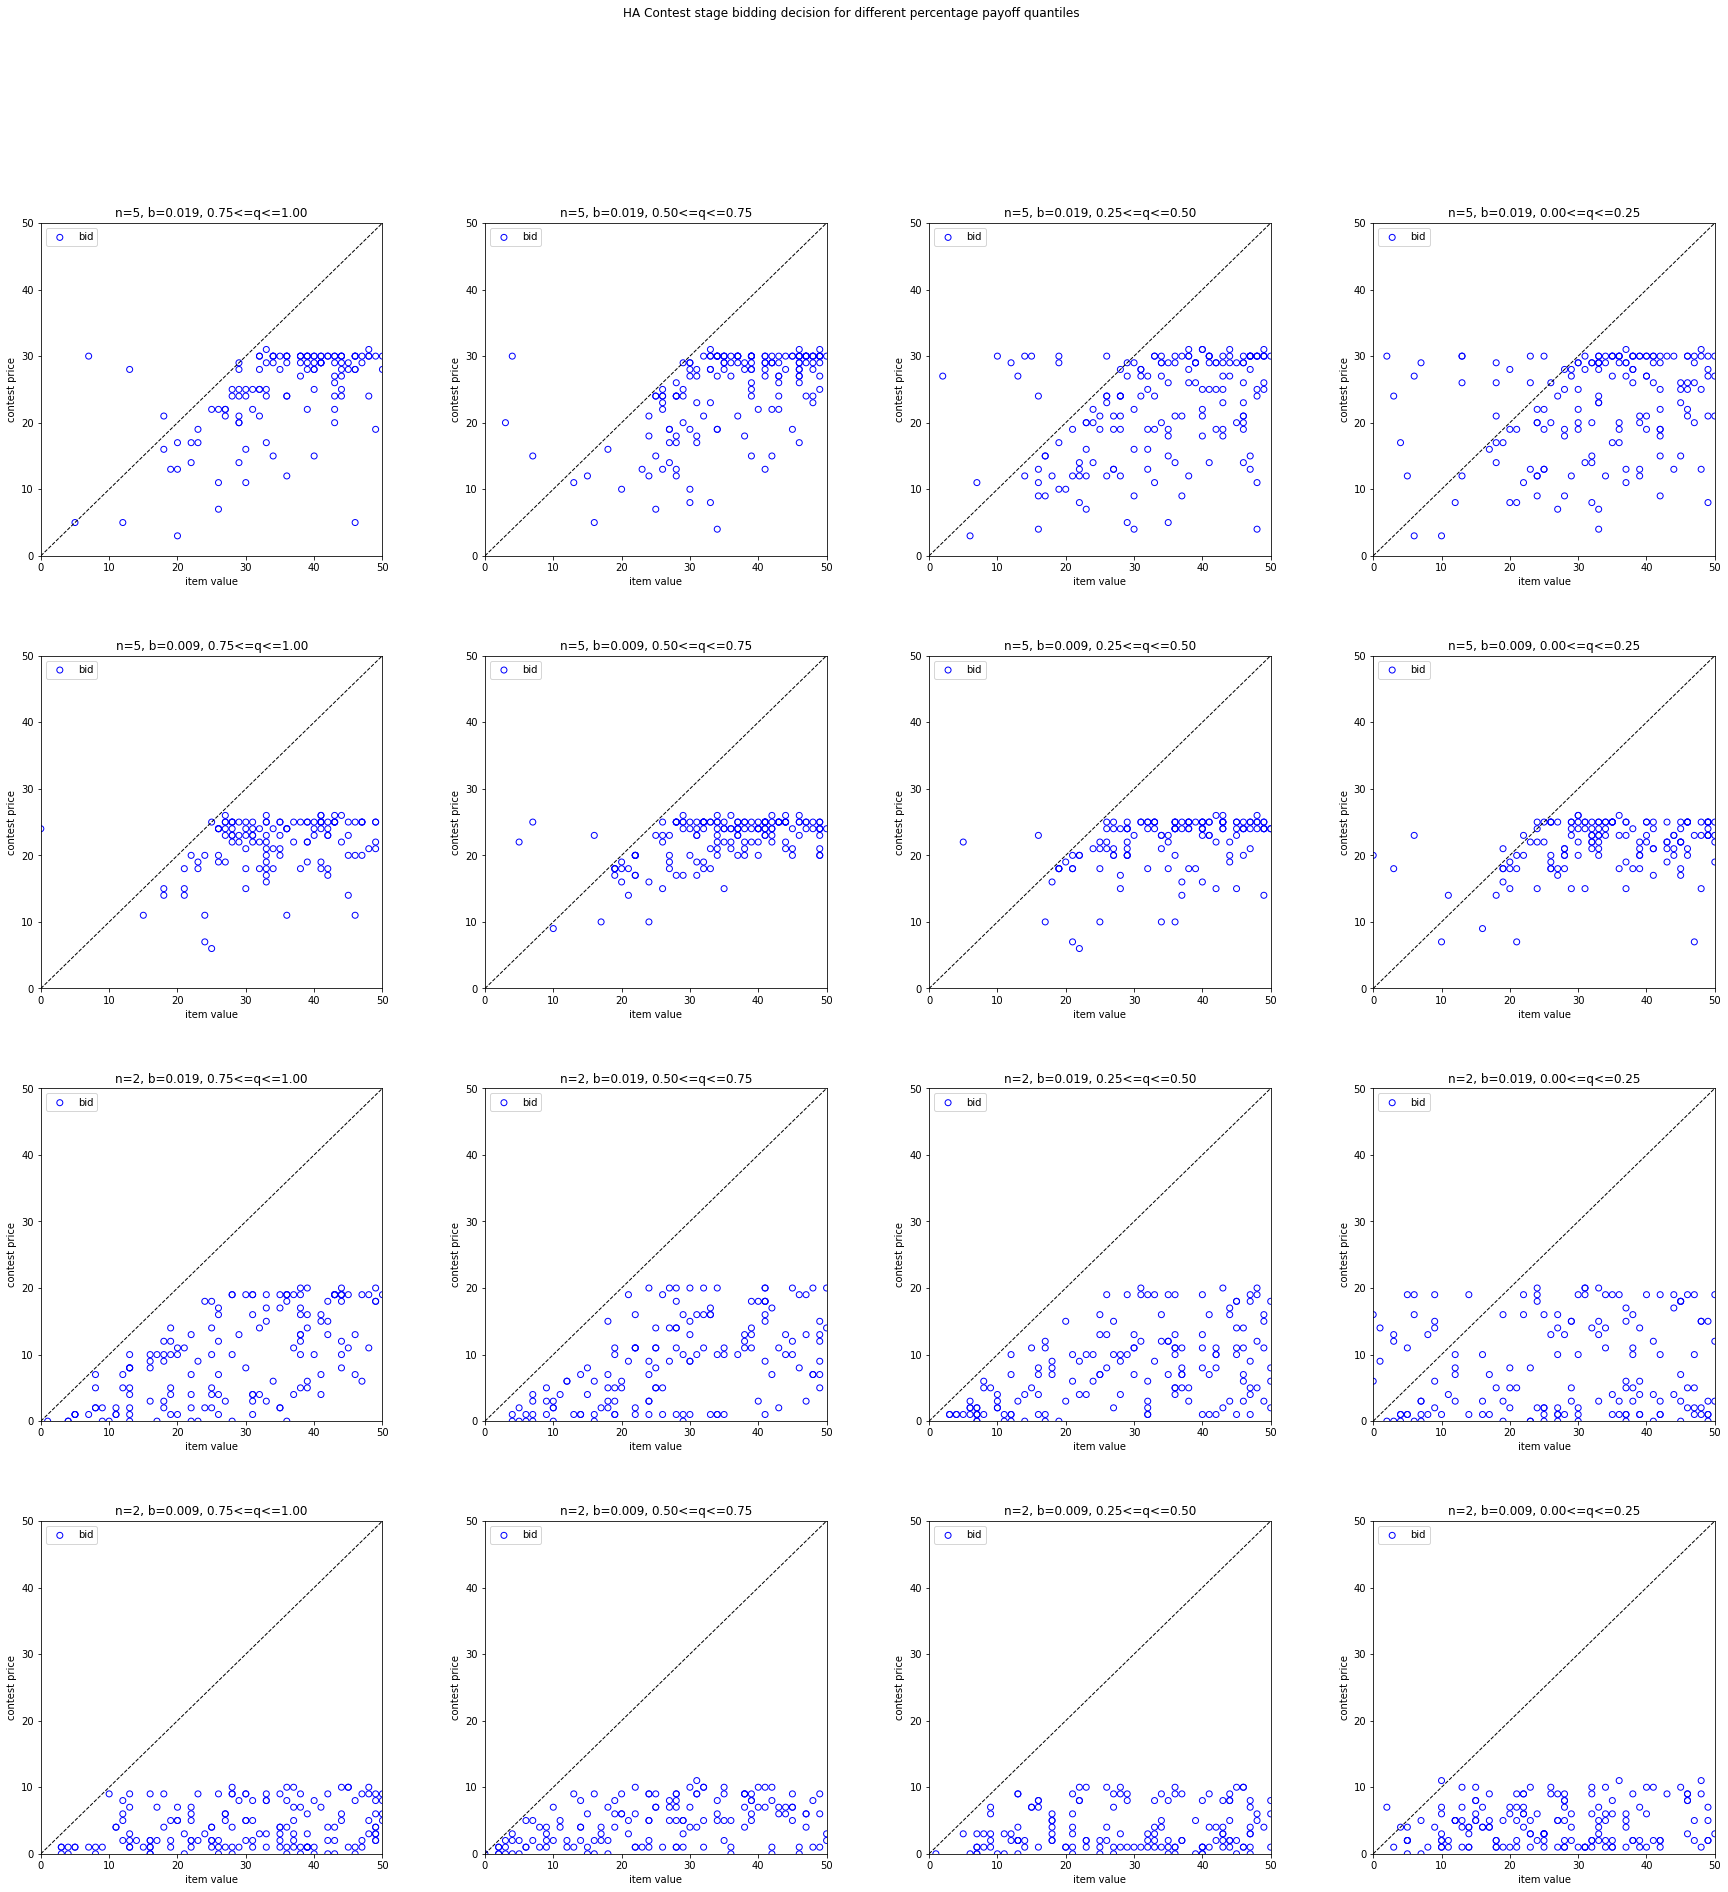

In [ ]:
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(4, 4, 1)
hContestPctdiffPlot(5, 0.019, 0.75, 1)
plt.subplot(4, 4, 2)
hContestPctdiffPlot(5, 0.019, 0.5, 0.75)
plt.subplot(4, 4, 3)
hContestPctdiffPlot(5, 0.019, 0.25, 0.5)
plt.subplot(4, 4, 4)
hContestPctdiffPlot(5, 0.019, 0, 0.25)
plt.subplot(4, 4, 5)
hContestPctdiffPlot(5, 0.009, 0.75, 1)
plt.subplot(4, 4, 6)
hContestPctdiffPlot(5, 0.009, 0.5, 0.75)
plt.subplot(4, 4, 7)
hContestPctdiffPlot(5, 0.009, 0.25, 0.5)
plt.subplot(4, 4, 8)
hContestPctdiffPlot(5, 0.009, 0, 0.25)
plt.subplot(4, 4, 9)
hContestPctdiffPlot(2, 0.019, 0.75, 1)
plt.subplot(4, 4, 10)
hContestPctdiffPlot(2, 0.019, 0.5, 0.75)
plt.subplot(4, 4, 11)
hContestPctdiffPlot(2, 0.019, 0.25, 0.5)
plt.subplot(4, 4, 12)
hContestPctdiffPlot(2, 0.019, 0, 0.25)
plt.subplot(4, 4, 13)
hContestPctdiffPlot(2, 0.009, 0.75, 1)
plt.subplot(4, 4, 14)
hContestPctdiffPlot(2, 0.009, 0.5, 0.75)
plt.subplot(4, 4, 15)
hContestPctdiffPlot(2, 0.009, 0.25, 0.5)
plt.subplot(4, 4, 16)
hContestPctdiffPlot(2, 0.009, 0, 0.25)
plt.suptitle("HA Contest stage bidding decision for different percentage payoff quantiles")

In [ ]:
def hEnglishPctdiffPlot(n, b, qmin, qmax):
    mindiff = np.quantile(list(h_dict_paydiff_pct[(n, b)].values()), qmin)
    maxdiff = np.quantile(list(h_dict_paydiff_pct[(n, b)].values()), qmax)
    p_code_list = [k for (k, v) in h_dict_paydiff_pct[(n, b)].items() if (v >= mindiff and v <= maxdiff)]
    tmp = df_h[df_h["participant.code"].isin(p_code_list)]
    tmpx1 = tmp[(tmp["player.contest_status"] == 1) & (tmp["player.is_english_winner"] == 0)]["player.item_value"]
    tmpy1 = tmp[(tmp["player.contest_status"] == 1) & (tmp["player.is_english_winner"] == 0)]["player.dropout_price"]
    # tmpx2 = tmp[(tmp["player.contest_status"] == 1) & (tmp["player.is_english_winner"] == 1)]["player.item_value"]
    # tmpy2 = tmp[(tmp["player.contest_status"] == 1) & (tmp["player.is_english_winner"] == 1)]["group.english_final_price"]
    plt.axline((0, 0), (50, 50), color="black", linewidth=1, linestyle="--")
    plt.scatter(tmpx1, tmpy1, marker="o", color="none", edgecolor="blue", label="not english winner")
    # plt.scatter(tmpx2, tmpy2, marker="+", color="orange", label="is english winner")
    plt.xlabel("item value")
    plt.ylabel("english leave/final price")
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.legend()
    plt.title("n=%d, b=%.3f, %.2f<=q<=%.2f" % (n, b, qmin, qmax))

Text(0.5, 0.98, "HA English stage non-winner's leave for different percentage payoff quantiles")

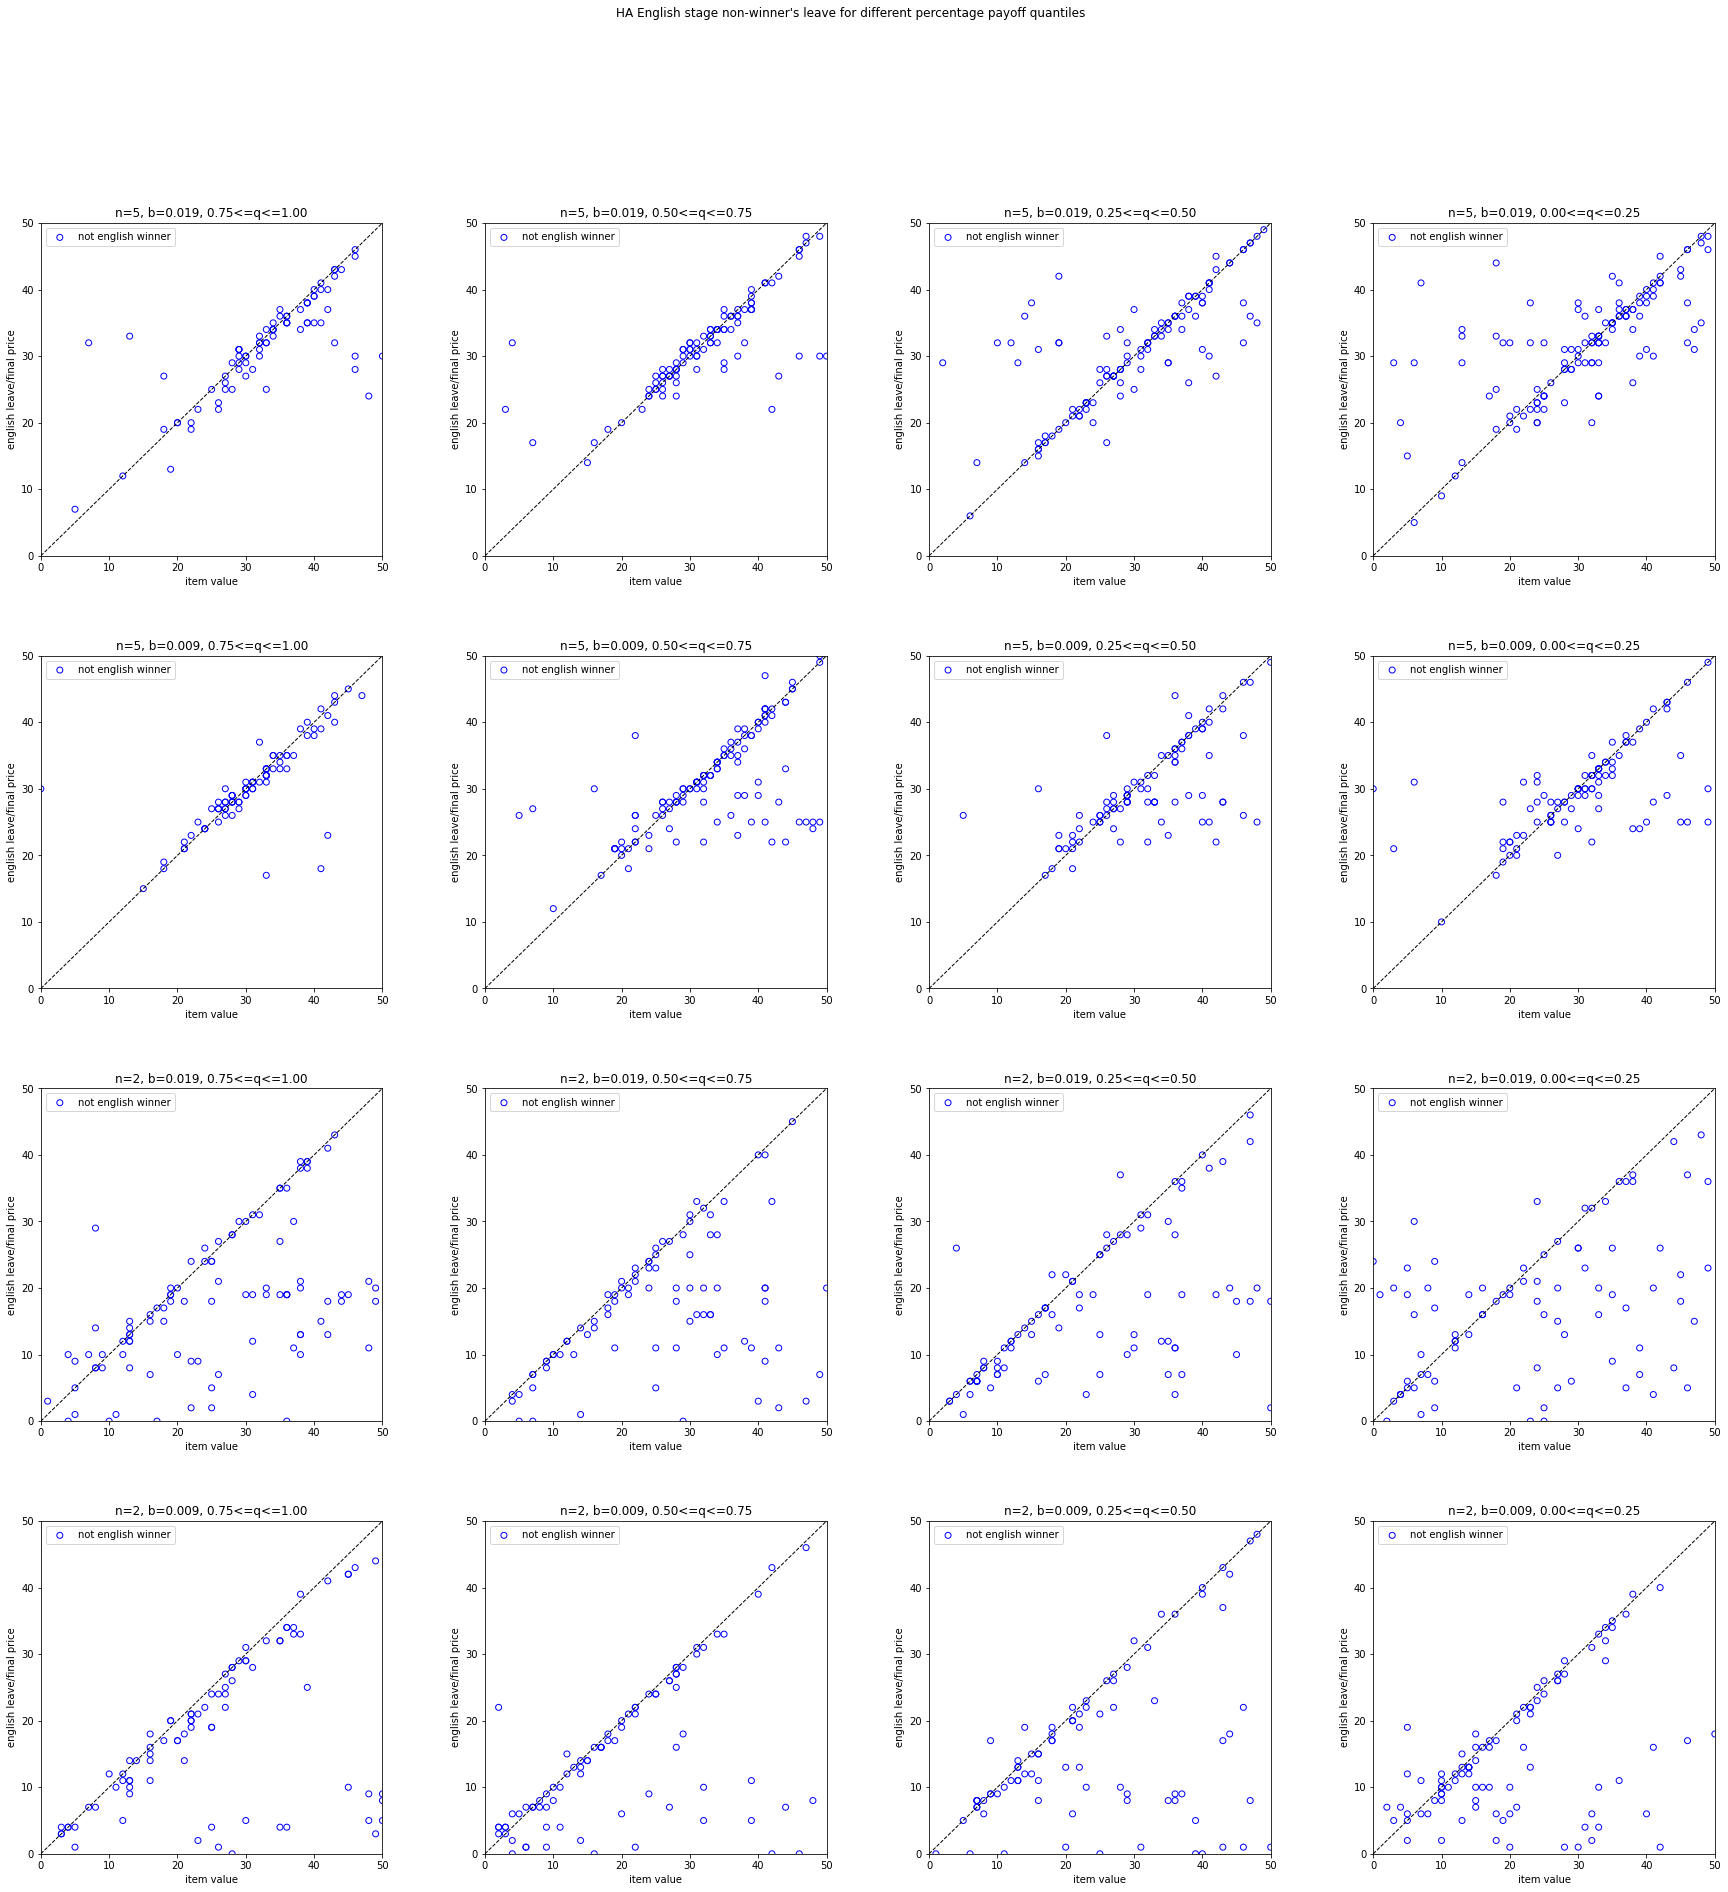

In [ ]:
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(4, 4, 1)
hEnglishPctdiffPlot(5, 0.019, 0.75, 1)
plt.subplot(4, 4, 2)
hEnglishPctdiffPlot(5, 0.019, 0.5, 0.75)
plt.subplot(4, 4, 3)
hEnglishPctdiffPlot(5, 0.019, 0.25, 0.5)
plt.subplot(4, 4, 4)
hEnglishPctdiffPlot(5, 0.019, 0, 0.25)
plt.subplot(4, 4, 5)
hEnglishPctdiffPlot(5, 0.009, 0.75, 1)
plt.subplot(4, 4, 6)
hEnglishPctdiffPlot(5, 0.009, 0.5, 0.75)
plt.subplot(4, 4, 7)
hEnglishPctdiffPlot(5, 0.009, 0.25, 0.5)
plt.subplot(4, 4, 8)
hEnglishPctdiffPlot(5, 0.009, 0, 0.25)
plt.subplot(4, 4, 9)
hEnglishPctdiffPlot(2, 0.019, 0.75, 1)
plt.subplot(4, 4, 10)
hEnglishPctdiffPlot(2, 0.019, 0.5, 0.75)
plt.subplot(4, 4, 11)
hEnglishPctdiffPlot(2, 0.019, 0.25, 0.5)
plt.subplot(4, 4, 12)
hEnglishPctdiffPlot(2, 0.019, 0, 0.25)
plt.subplot(4, 4, 13)
hEnglishPctdiffPlot(2, 0.009, 0.75, 1)
plt.subplot(4, 4, 14)
hEnglishPctdiffPlot(2, 0.009, 0.5, 0.75)
plt.subplot(4, 4, 15)
hEnglishPctdiffPlot(2, 0.009, 0.25, 0.5)
plt.subplot(4, 4, 16)
hEnglishPctdiffPlot(2, 0.009, 0, 0.25)
plt.suptitle("HA English stage non-winner\'s leave for different percentage payoff quantiles")